
## Shaft model with weighted sigma vector for PDF shaping (656 samples)

This model trains in 2 phases. First in the standard ML approach and and the second phase using PDF shaping.

The model consists of the sum of a linear function and a non-linear function with PDF shaping and weighting.

This model uses the CFD Shaft data with 656 samples. 

## Web application 6 inputs and 5 outputs

Run interactively on the web at:

## Inputs

(1, 'i_pul_coal_inj_kg_thm')

(2, 'i_nat_gas_inj_kg_thm')

(3, 'i_nat_gas_t_k')

(4, 'i_o2_vol_perce')

(9, 'i_ore_moisture_weight_perce')

(11, 'i_ore_weight_kg')

## Outputs

(19, 'o_shaft_co_utiliz')

(20, 'o_shaft_h2_utiliz')

(21, 'o_shaft_top_gas_temp_c')

(22, 'o_shaft_press_drop_pa')

(23, 'o_shaft_coke_rate_kg_thm')


In [1]:


################################################
##
## regression with ML for system control
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch

from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity
##from torch.distributions import MultivariateNormal, Normal
##from torch.distributions.distribution import Distribution
## from sklearn.datasets import make_blobs
## from torch.optim import LBFGS

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


In [73]:

#######################################################
## learning_rate_mse        = 0.0005
## probably needs adjustable learning rate scheduler


N_EPOCHS     = 4000                            
N_EPOCHS_PDF = 1000

########################################################

batch_size = 16    

learning_rate =  0.1   ## 0.1                        ## 0.01   ## 1e-5 

## 0.0001  experimentally seemed okay 
learning_rate_pdfcontrol  =  0.0001      ## 0.0001     ## 0.00001       ## 0.000001

#######################################################
# define mean and standard deviation of target Gaussian distribution (impulse function)

mean_impulse = 0.
std_impulse  = 0.01

#######################################################


## experimentally 0.5 - 0.7 was interesting      ## 0.9
h = 0.9       ## 0.7    ## 0.05     ## 0.03                    ## 0.05 >


## experimentally 20 seemed okay 
N_error_range =  20          ## 20  ## 10   ## error between pred and real range (-20, 20)


#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################
## regularization function

use_sigma_weighting = 0.0

#######################################################
## 0.2 more jagged
## 2 more smooth
## analogous to selecting number of basis functions?

bandwidth = 0.2



In [74]:

CFD_raw_data = pd.read_csv('CFD.10.2022.csv')


In [4]:

headers_list = CFD_raw_data.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))


['index', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_ore_moisture_weight_perce', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_production_rate_thmperday', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
29
(0, 'index')
(1, 'i_pul_coal_inj_kg_thm')
(2, 'i_nat_gas_inj_kg_thm')
(3, 'i_nat_gas_t_k')
(4, 'i_o2_vol_perce')
(5, 'i_bf_windrate_nm3_hr')
(6, 'i_hb_moist_g_nm3')
(7, 'i_hot_blast_press_pa')
(8, 'i_hot_blast_temp_k')
(9, 'i_ore_moisture_weight_perce')
(10, 'i_coke_weight_kg')
(11, 'i_ore_weight_kg')
(12, 'o_production_rate_

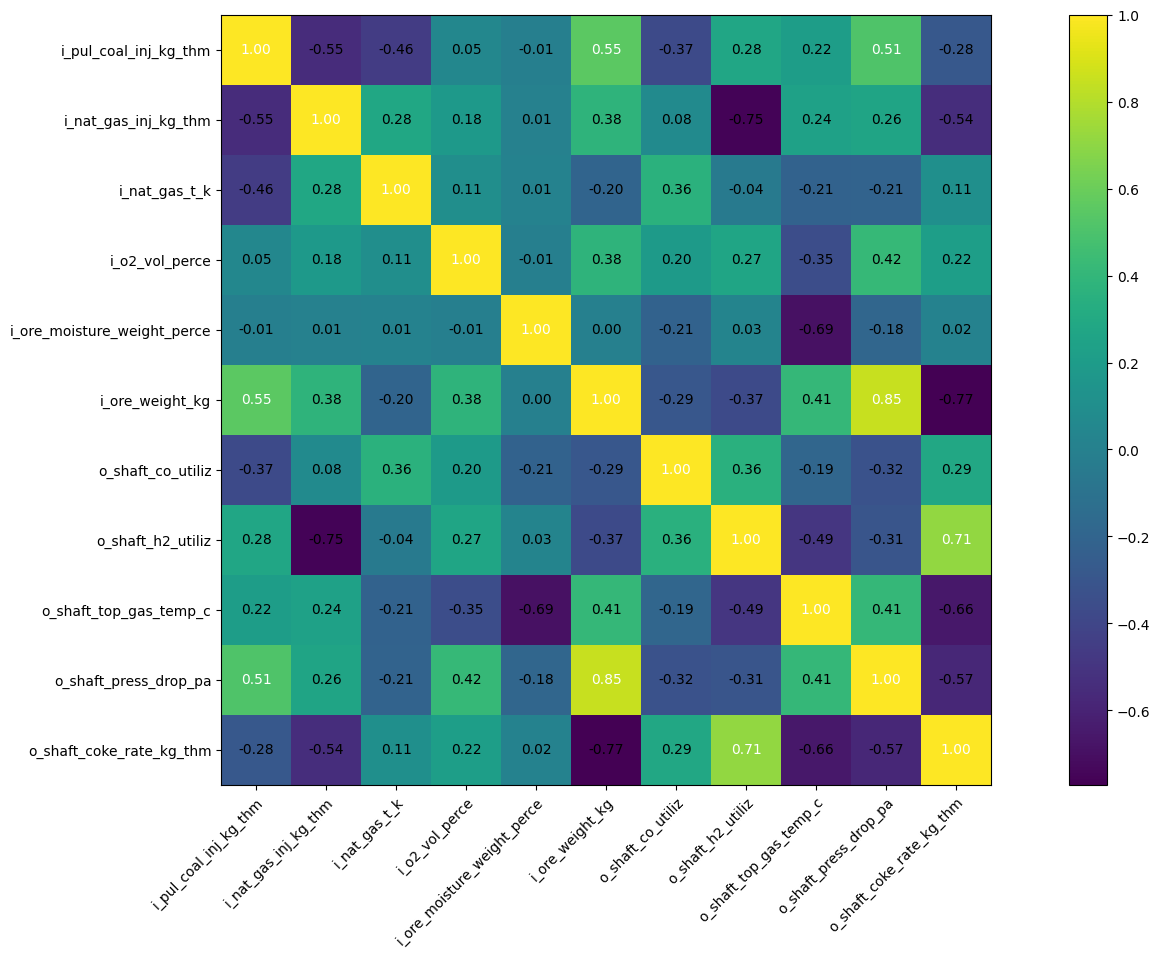

In [5]:

my_allInputs_shaft_names = ['i_pul_coal_inj_kg_thm','i_nat_gas_inj_kg_thm','i_nat_gas_t_k','i_o2_vol_perce',
                            'i_ore_moisture_weight_perce', 'i_ore_weight_kg', 'o_shaft_co_utiliz', 
                            'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 
                            'o_shaft_coke_rate_kg_thm']



cm = np.corrcoef(CFD_raw_data[my_allInputs_shaft_names].values.T)
hm = heatmap(cm, row_names=my_allInputs_shaft_names, column_names=my_allInputs_shaft_names, figsize=(20, 10))
plt.show()


In [6]:

CFDdata_np = CFD_raw_data.to_numpy()
print(CFDdata_np)
print(CFDdata_np.shape)


[[  1.           0.          37.9        ...   0.1941631    0.0438327
    0.5448123 ]
 [  2.           0.          37.9        ...   0.2186134    0.04034286
    0.5149459 ]
 [  3.           0.          37.9        ...   0.2353341    0.03772617
    0.4849808 ]
 ...
 [654.           0.         150.         ...   0.2177873    0.1135979
    0.4338012 ]
 [655.           0.         150.         ...   0.1865845    0.1268458
    0.4743676 ]
 [656.           0.         150.         ...   0.2246319    0.1110198
    0.4373359 ]]
(656, 29)


In [7]:

#######################################################

input_indeces  = [1, 2, 3, 4, 9, 11]
output_indeces = [19, 20, 21, 22, 23]                            

#######################################################

X = CFDdata_np[:, input_indeces]

y = CFDdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

#######################################################

random_seed = int( random.random() * 100  )         ## 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_seed)

#######################################################

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(656, 6)
(656, 5)
(524, 6)
(132, 6)
(524, 5)
(132, 5)


In [8]:

## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)


## Scale inputs (x)

In [9]:

###################################################################
## for scaling

epsilon = 0.0001

x_means      =  X_train_tr.mean(0, keepdim=True)
x_deviations =  X_train_tr.std(0, keepdim=True) + epsilon

X_train_tr_scaled = (X_train_tr - x_means) / x_deviations
X_test_tr_scaled  = (X_test_tr  - x_means) / x_deviations


## Scale outputs (y)

In [10]:

###################################################################
## standardize the y outputs

y_means      = y_train_tr.mean(0, keepdim=True)
y_deviations = y_train_tr.std(0,  keepdim=True) + epsilon

y_train_tr_scaled = (y_train_tr - y_means) / y_deviations
y_test_tr_scaled  = (y_test_tr - y_means) / y_deviations

####################################################################


## Fit and Train Functions

In [11]:
def func_plot_performance(list_metric, the_string):
    
    list_samples = [i for i in range(len(list_metric))]
    
    plt.figure(figsize=(13,4))
    
    plt.scatter(list_samples, list_metric)
    
    ## plt.xlim(-1, 1)
    plt.ylim(0.7, 1.03)
    
    plt.title('metric during training ' + the_string)
    plt.xlabel('iteration/epoch')
    plt.ylabel('R**2')
    ## plt.legend()
    
    file_name = 'images/300dpiShaft' + the_string + '.png'
    plt.savefig(file_name, dpi=300)

    plt.show()

In [12]:

def fit_y_scaled(num_epochs, model, loss_fn, opt):
    list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ## print(epoch, " loss= ", loss)
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(X_train_tr)
        r2_avg = torch.mean(torch.tensor(r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  )))
        list_metric.append(r2_avg.detach().numpy())
            
    func_plot_performance(list_metric, "No PDF shaping")
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))
    
#######################################################


## With PDF shaping, 2 phases are performed. 

In [77]:
#######################################################


def fit_y_scaled_PDF(num_epochs, num_epochs_pdf, model, loss_fn, loss_fn_PDF, opt):
    
    list_metric = []
    
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
        
        pred_descaled, pred_scaled = model(X_train_tr)
        r2_avg = torch.mean(torch.tensor(r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  )))
        list_metric.append(r2_avg.detach().numpy())
        
        
    opt = torch.optim.Adam(   model.parameters(), lr=learning_rate_pdfcontrol   )    
        
    for epoch in range(num_epochs_pdf):
        
        pred_descaled, pred_scaled = model(X_train_tr)
        loss = loss_fn_PDF(  epoch, pred_scaled,    y_train_tr_scaled  )
        loss.backward()
        opt.step()
        opt.zero_grad()
        

        print(epoch, " loss= ", loss)
        
            
        ## pred_descaled, pred_scaled = model(X_train_tr)
        r2_avg = torch.mean(torch.tensor(r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  )))
        list_metric.append(r2_avg.detach().numpy())
        
        
            
    func_plot_performance(list_metric, "With PDF shaping")
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))
    
#######################################################

## DataLoaders

In [14]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr_scaled)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

## Define NN architectures

In [15]:
#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 5) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 5)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 5)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      
#############################################################

In [16]:

#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(6, 5)       
        
        ## F2
        self.f2_linear1 = nn.Linear(6, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 5)       
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################


## Impulse Function for PDF shaping

Uses a gaussian basically

In [17]:

def ImpulseGaussian(x, mu, sigma): 
   
    left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   ) * torch.sqrt(torch.tensor(sigma) )    )
    
    right = torch.exp(   -(x - mu)**2 / (2 * sigma)    )
    
    vector_vals = left * right
    
    return vector_vals         ## .unsqueeze(0)


The variable left ends up being 1 scalar value. The variable right ends up being a vector of size 4000. The variable x is the range of errors from -N to N such as:

[-20, 19, ..., 0, ..., 19, 20].

N is selected. it is assumed that error diffs above 20 are rare.

The value mu is a scalar 0. A broadcast substraction is taken between the vector of size 4000 and the scalar 0. This results in a new vector of size 4000 which defines the impulse function. For example:

## Example and explanation (skip)

torch.Size([4000])


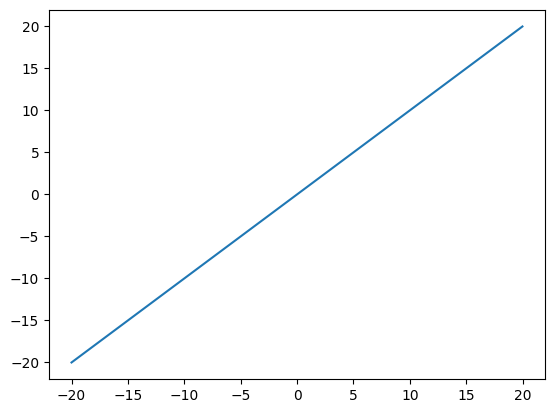

torch.Size([4000])


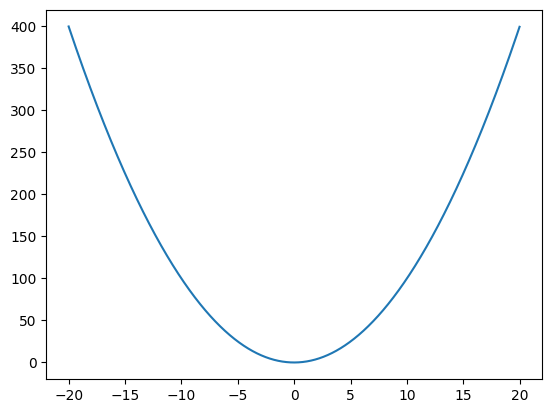

torch.Size([4000])


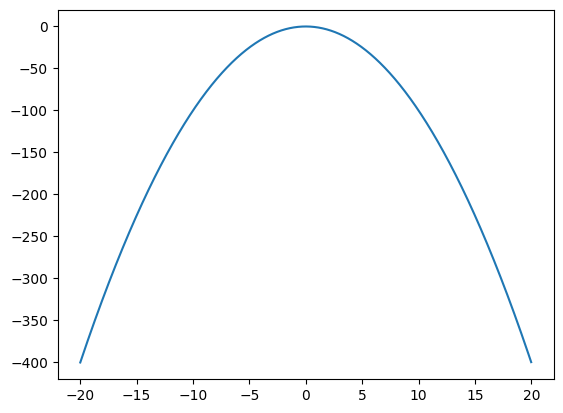

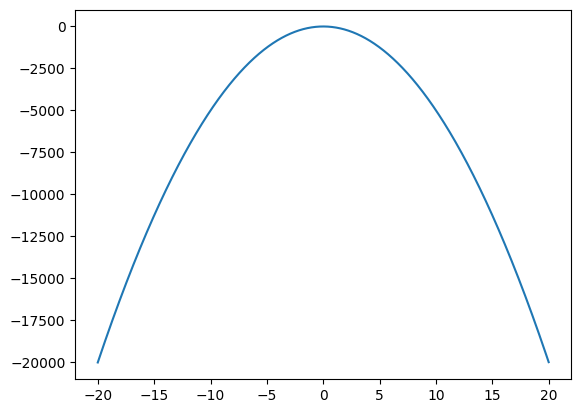

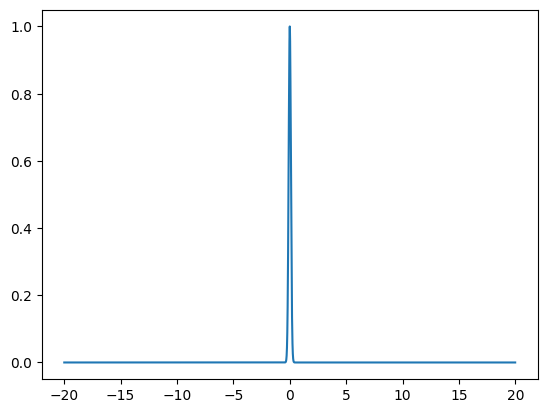

tensor(3.9894)


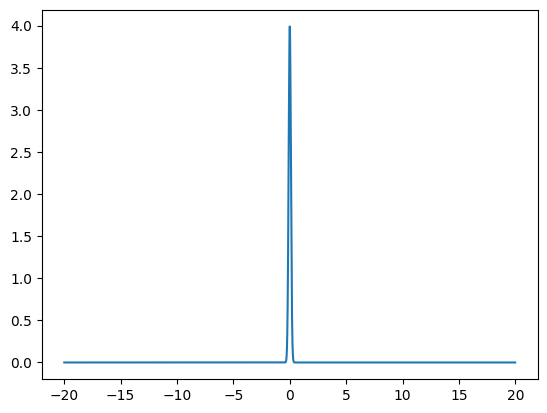

torch.Size([4000])


In [18]:

example_temp_x = torch.arange(-20, 20, 0.01)  

example_diff_range = example_temp_x - 0.0
print(example_diff_range.size())
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = (example_temp_x - 0.0)**2
print(example_diff_range.size())
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = -(example_temp_x - 0.0)**2
print(example_diff_range.size())
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = -(example_temp_x - 0.0)**2 / (2 * 0.01) 
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = torch.exp( -(example_temp_x - 0.0)**2 / (2 * 0.01) )
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_temp_left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   ) * torch.sqrt(torch.tensor(0.01) )    )
print(example_temp_left )

example_diff_range  = example_temp_left * example_diff_range 
plt.plot(example_temp_x, example_diff_range )
plt.show()

print(example_diff_range.size())


In [19]:
example_diff_range 

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [20]:
example_diff_range[1970:2030]

tensor([0.0443, 0.0595, 0.0792, 0.1042, 0.1358, 0.1753, 0.2239, 0.2833, 0.3547,
        0.4398, 0.5399, 0.6562, 0.7895, 0.9405, 1.1092, 1.2952, 1.4973, 1.7137,
        1.9419, 2.1785, 2.4197, 2.6609, 2.8969, 3.1225, 3.3322, 3.5207, 3.6827,
        3.8139, 3.9104, 3.9695, 3.9894, 3.9695, 3.9104, 3.8139, 3.6827, 3.5207,
        3.3322, 3.1225, 2.8969, 2.6609, 2.4197, 2.1785, 1.9419, 1.7137, 1.4973,
        1.2952, 1.1092, 0.9405, 0.7895, 0.6562, 0.5399, 0.4398, 0.3547, 0.2833,
        0.2239, 0.1753, 0.1358, 0.1042, 0.0792, 0.0595])

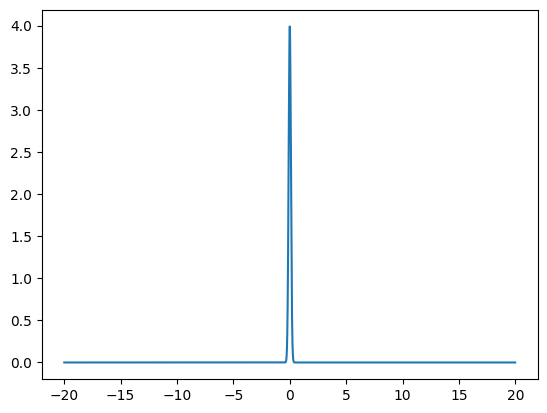

In [21]:

example_temp_y = ImpulseGaussian(example_temp_x, 0, 0.01)

plt.plot(example_temp_x, example_temp_y )


SHOULD ADD UP to 100.0 (i.e. 1.0)

In [22]:
sum(example_temp_y)

tensor(100.0000)

Kernel Density Estimation for PDF approximation assuming known gaussian error distribution

In [23]:
def kernel_density(x_range, the_errors, h): 
    
    x_range = x_range.unsqueeze(0)
   
    the_errors = the_errors.unsqueeze(2)
    
    
    left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   )  )
    
    right = torch.exp(   -((x_range - the_errors)/h)**2 / (2)    )
    
    vector_vals = left * right
    
    ## density         = torch.mean( vector_vals, 0) / h
             
    return vector_vals

The kernel function does something very similar to the impulse function. The kernel helps to create the other pdf for the errors in the range [-N, N]. The difference is that now we have batches and multiple outputs. If we had a batch of 1, with one output, then

y_pred - y_real = error

would give one scalar error value such as 2.3 or something. The 0 scalar value is what we would want if we had 100% accuracy. But we can assume an error scalar value such as 2.3.

the_errors variable below has a dimentions of [16x5] because we have batches of 16 and 5 outputs. Exactly like with the impulse func, we need the error range. The variable x_range is the range of errors from -N to N such as:

[-20, 19, ..., 0, ..., 19, 20].

N is selected. It is assumed that error differences above 20 are rare.

Since we have batches of 16 and 5 outputs, we take the broadcast diff between each of the values in the_errors and the x_range. A broadcast substraction is taken between the vector x_range of size 4000 and the values in the [16, 5] matrix. This results in a new matrix of size [16, 5, 4000].

The logic is the same as the impulse func, instead of zero like in the impulse func, for the kernel_density we have the loss errors

y_pred - y_real = error

so assume the value for batch 3 and output 4, we have value 2.3. This was the error (y_pred - y_real ). Now like with the impulse func, we need the pdf of that error so we compare it to the vector range x of 4000 and a broadcast substraction is taken between the vector x_range of size 4000 and the value [3, 4] = 2.3

For efficiency, this is generalized with tensor matrix multiplications and broadcasting.

Now we repeat the plotting as we did for the impulse function but for the error value [3, 4] = 2.3

torch.Size([4000])


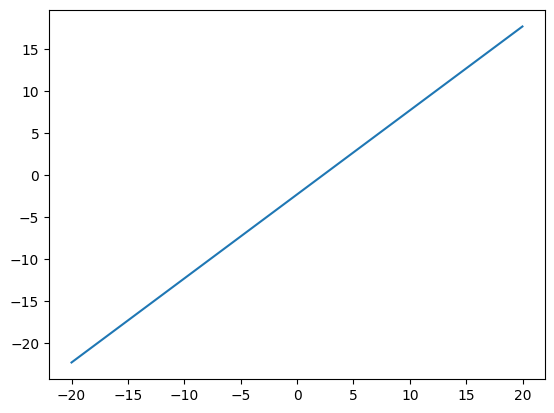

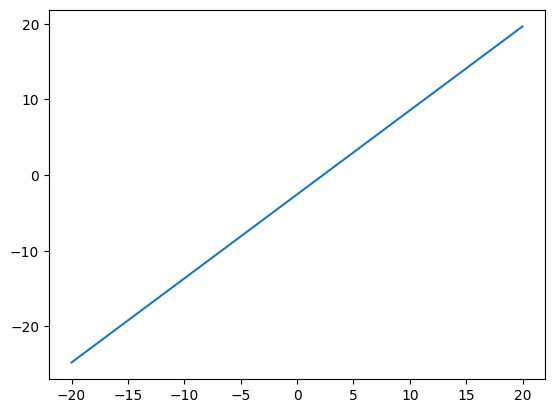

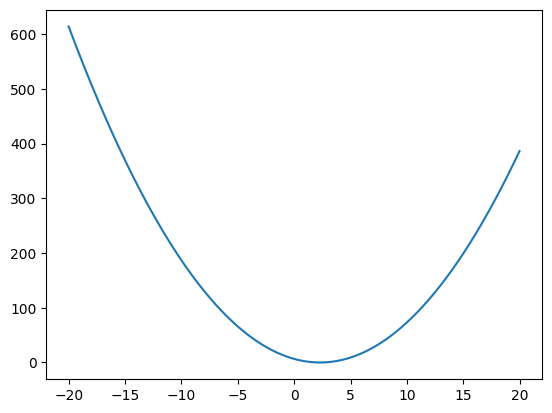

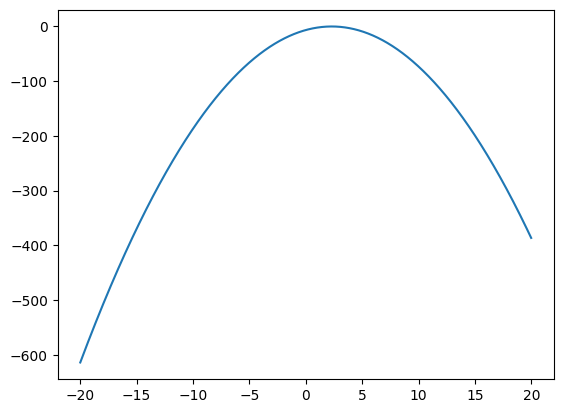

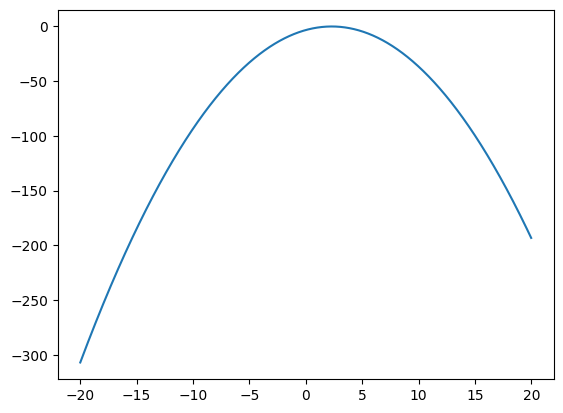

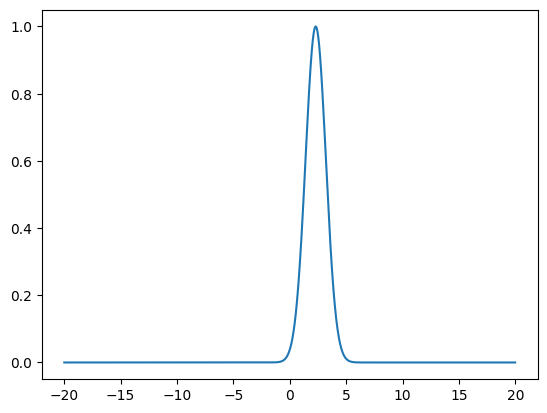

tensor(0.3989)


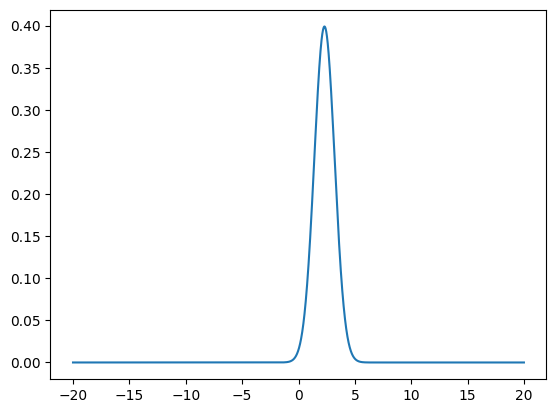

In [24]:
example_temp_x = torch.arange(-20, 20, 0.01)  

example_diff_range = example_temp_x - 2.3
print(example_diff_range.size())
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = (example_temp_x - 2.3)/h
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = (   (example_temp_x - 2.3)/h    )**2
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = -(   (example_temp_x - 2.3)/h    )**2
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = -(   (example_temp_x - 2.3)/h    )**2 / (2)
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range =   torch.exp(  -(   (example_temp_x - 2.3)/h    )**2 / (2)   )
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_temp_left = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   )  )
print(example_temp_left )
example_diff_range =   torch.exp(  -(   (example_temp_x - 2.3)/h    )**2 / (2)   )
example_diff_range  = example_temp_left * example_diff_range 
plt.plot(example_temp_x, example_diff_range )
plt.show()

In [25]:
example_diff_range

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [26]:
example_diff_range[1970:2030]

tensor([0.0061, 0.0063, 0.0066, 0.0068, 0.0070, 0.0072, 0.0074, 0.0077, 0.0079,
        0.0082, 0.0084, 0.0087, 0.0090, 0.0092, 0.0095, 0.0098, 0.0101, 0.0104,
        0.0107, 0.0111, 0.0114, 0.0117, 0.0121, 0.0124, 0.0128, 0.0132, 0.0136,
        0.0140, 0.0144, 0.0148, 0.0152, 0.0157, 0.0161, 0.0166, 0.0170, 0.0175,
        0.0180, 0.0185, 0.0190, 0.0196, 0.0201, 0.0207, 0.0212, 0.0218, 0.0224,
        0.0230, 0.0236, 0.0242, 0.0249, 0.0255, 0.0262, 0.0269, 0.0276, 0.0283,
        0.0291, 0.0298, 0.0306, 0.0313, 0.0321, 0.0329])

In [27]:
example_diff_range[2000:2500]

tensor([0.0152, 0.0157, 0.0161, 0.0166, 0.0170, 0.0175, 0.0180, 0.0185, 0.0190,
        0.0196, 0.0201, 0.0207, 0.0212, 0.0218, 0.0224, 0.0230, 0.0236, 0.0242,
        0.0249, 0.0255, 0.0262, 0.0269, 0.0276, 0.0283, 0.0291, 0.0298, 0.0306,
        0.0313, 0.0321, 0.0329, 0.0338, 0.0346, 0.0355, 0.0364, 0.0372, 0.0382,
        0.0391, 0.0400, 0.0410, 0.0420, 0.0430, 0.0440, 0.0450, 0.0461, 0.0471,
        0.0482, 0.0494, 0.0505, 0.0516, 0.0528, 0.0540, 0.0552, 0.0564, 0.0577,
        0.0590, 0.0602, 0.0616, 0.0629, 0.0642, 0.0656, 0.0670, 0.0684, 0.0699,
        0.0713, 0.0728, 0.0743, 0.0758, 0.0774, 0.0790, 0.0805, 0.0822, 0.0838,
        0.0854, 0.0871, 0.0888, 0.0905, 0.0923, 0.0940, 0.0958, 0.0976, 0.0995,
        0.1013, 0.1032, 0.1051, 0.1070, 0.1090, 0.1109, 0.1129, 0.1149, 0.1169,
        0.1190, 0.1210, 0.1231, 0.1252, 0.1274, 0.1295, 0.1317, 0.1339, 0.1361,
        0.1383, 0.1406, 0.1428, 0.1451, 0.1474, 0.1497, 0.1521, 0.1544, 0.1568,
        0.1592, 0.1616, 0.1640, 0.1664, 

In [28]:
a = torch.tensor([[1,  9,  8, 7],
        [2,  1.0131, -0.6549, -1.4279],
        [3, -1.3350, -0.7694,  0.5600],
        [ 3, -0.9580,  0.3623,  0.2343]])
print(   torch.mean(a, 0)   )

tensor([2.2500, 1.9300, 1.7345, 1.5916])



Custom loss function for PDF shaping

The tenmsor x should be [-N, N] of size 4000 given my choice of step and N. The errors tensor becomes of size [16, 5] as it is [batches, outputs]. Impulse function returns a vector of size 4000 as previously described. Kernel desity returns a tensor of size [16, 5, 4000].

diff should be [16, 5, 4000]

In [29]:
x =torch.randint(3, 5, (3,))
y = torch.randint(10, (2, 4, 3))
print(x.size())
print(x)
print(y)
print(y.size())
res = y - x
print(res)
## print(   torch.mean(a, 0)   )

torch.Size([3])
tensor([3, 4, 4])
tensor([[[9, 2, 7],
         [4, 7, 4],
         [5, 4, 1],
         [9, 6, 8]],

        [[6, 3, 1],
         [7, 7, 0],
         [1, 2, 7],
         [9, 9, 2]]])
torch.Size([2, 4, 3])
tensor([[[ 6, -2,  3],
         [ 1,  3,  0],
         [ 2,  0, -3],
         [ 6,  2,  4]],

        [[ 3, -1, -3],
         [ 4,  3, -4],
         [-2, -2,  3],
         [ 6,  5, -2]]])


loss when error distribution is known to be gaussian

In [30]:
def my_loss(output, target):
    
    x = torch.arange(-N_error_range, N_error_range, 0.01)                   ## the error is in this range 
    
    error = output.float() - target.float() 
    
    basisFunc   =  kernel_density(x, error, h)
    
    impulseFunc = ImpulseGaussian(x, mean_impulse, std_impulse**2)  
    
    ## print(basisFunc.size())
    ## print(impulseFunc.size())
    
    diff = ( basisFunc.float() -  impulseFunc.float()  )        ## * h         ## h is ?? 
    ## print(  diff.size()   )
    
    ## there are 5 ish values and 3995 zeros, so get rid of zeros
    ## and then take the mean
    
    diffs_vector  = torch.reshape(diff, (-1,))
    diffs_vector = diffs_vector[diffs_vector > ignore_losses_threshold]
    
    diff = diffs_vector
    
    ## print(diff)
    ## print(   diff.size()  )
    
    loss = torch.mean(   (   diff  )**2    )    ## / h
    
    reg_sigma_func = (loss ** 2) * use_regularization
    
    loss = loss * ( 1.0 + reg_sigma_func )
    
    return loss

explanation of Loss for Unknown error PDF

Assume 400 predicted errors with Unknown distribution

In [31]:
error11 = normal(loc=7, scale=3, size=300)
error12 = normal(loc=-7, scale=3, size=100)
errors_EXAMPLE1 = hstack((error11, error12))

error21 = normal(loc=3, scale=4, size=300)
error22 = normal(loc=-3, scale=4, size=100)
errors_EXAMPLE2 = hstack((error21, error22))

error31 = normal(loc=4, scale=3, size=300)
error32 = normal(loc=-4, scale=3, size=100)
errors_EXAMPLE3 = hstack((error31, error32))

error41 = normal(loc=6, scale=2, size=300)
error42 = normal(loc=-6, scale=2, size=100)
errors_EXAMPLE4 = hstack((error41, error42))

error51 = normal(loc=5, scale=4, size=300)
error52 = normal(loc=-5, scale=4, size=100)
errors_EXAMPLE5 = hstack((error51, error52))

matrix_of_errors = vstack( (errors_EXAMPLE1, errors_EXAMPLE2, errors_EXAMPLE3, errors_EXAMPLE4, errors_EXAMPLE5) )

matrix_of_errors = torch.tensor( matrix_of_errors.T )

print(matrix_of_errors.shape)



torch.Size([400, 5])


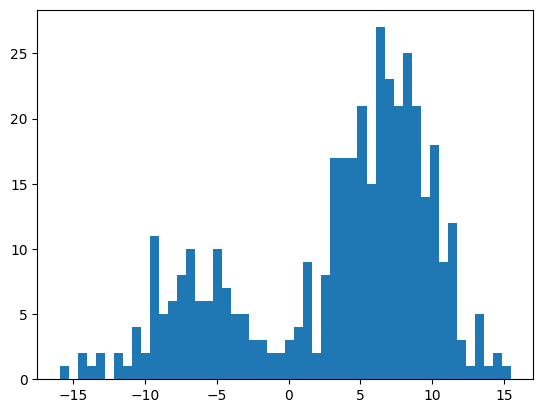

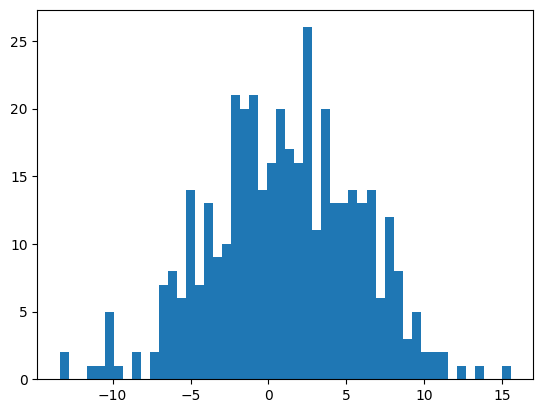

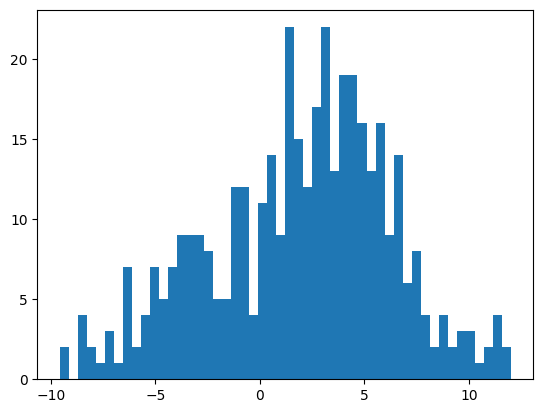

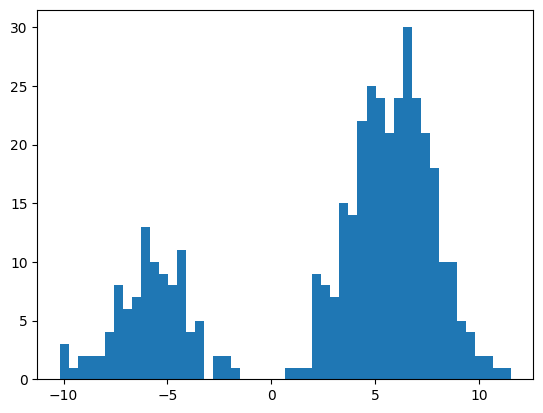

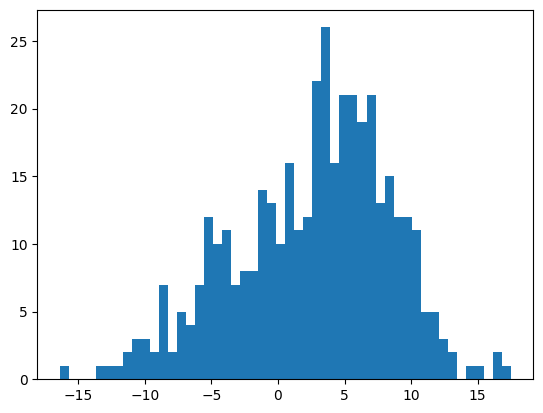

In [32]:

plt.hist(matrix_of_errors[:, 0], bins=50)
plt.show()
plt.hist(matrix_of_errors[:, 1], bins=50)
plt.show()
plt.hist(matrix_of_errors[:, 2], bins=50)
plt.show()
plt.hist(matrix_of_errors[:, 3], bins=50)
plt.show()
plt.hist(matrix_of_errors[:, 4], bins=50)
plt.show()


In [33]:
print(matrix_of_errors[:].shape)
matrix_of_errors[:]

torch.Size([400, 5])


tensor([[  5.6423,   3.8127,   2.8814,   3.1186,   7.1540],
        [  5.1998,  -1.5118,   5.9176,   3.2982,   8.5482],
        [  8.0550,  -3.3152,   1.0530,   4.6933,   8.8141],
        ...,
        [ -8.2801, -10.3456,  -1.7404,  -7.1186,   3.1601],
        [ -8.9018,  -2.0693,  -4.5887,  -7.0940,  -6.9864],
        [ -6.9203,   0.4754,  -1.8735,  -4.8594,  -4.5083]],
       dtype=torch.float64)

Learn the function that predicts the unknown error distribution

sum of basis funcs (e.g. sum of gaussians)

## KDE gaussian approximation in Torch

In [34]:
'''
def kernel_density(K, sample, h):
    
    def return_K(errors_400):
        for i, error_val in enumerate(errors_400): 
            errors_400[i] = 1 * torch.exp(-error_val**2/2) / torch.sqrt(2 * torch.tensor(math.pi))
        return x
    

    def f(y, sample):
             
        res =   (y - sample)/h  
        for i, res_val in enumerate(res):
            res[i] = return_K(res_val)
             
        return torch.mean(res) / h
    

    
    def func(data_4k):
        for i, x_axis_val in enumerate(data_4k):
            data_4k[i] = f(x_axis_val, data_4k)
        return data_4k
    
    return func
'''

'\ndef kernel_density(K, sample, h):\n    \n    def return_K(errors_400):\n        for i, error_val in enumerate(errors_400): \n            errors_400[i] = 1 * torch.exp(-error_val**2/2) / torch.sqrt(2 * torch.tensor(math.pi))\n        return x\n    \n\n    def f(y, sample):\n             \n        res =   (y - sample)/h  \n        for i, res_val in enumerate(res):\n            res[i] = return_K(res_val)\n             \n        return torch.mean(res) / h\n    \n\n    \n    def func(data_4k):\n        for i, x_axis_val in enumerate(data_4k):\n            data_4k[i] = f(x_axis_val, data_4k)\n        return data_4k\n    \n    return func\n'

In [35]:


def kernel_density(K, sample, h):
    
    f = lambda y: torch.mean(
                    functorch.vmap(K)     ((y - sample)/h)
        ) / h
    
    return functorch.vmap(f)


In [36]:


K = lambda x: 1 * torch.exp(-x**2/2) / torch.sqrt(2 * torch.tensor(math.pi))



In [37]:
## Bandwidth (smoothing parameter) is a window size required by the algorithm that controls 
## The kernel is the basis function. 


def sum_of_basis_func(K, errors, bandwidth):
    
    ## model = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    ## errors = errors.reshape(  (len(errors), 1)   )              ## 400x1
    ## model.fit(errors)
    
    model = kernel_density(K, errors, h=bandwidth)
    
    return model


## Example (skip)

In [38]:

basis_func_trained_list = []

print(matrix_of_errors.shape[1])

for i in range(  matrix_of_errors.shape[1]   ):
    print(i)
    print(   matrix_of_errors[:,i].shape     )
    basis_func_trained_list.append(    sum_of_basis_func( K, matrix_of_errors[:,i] ,  bandwidth)        )   
                       
                       
len(basis_func_trained_list )



5
0
torch.Size([400])
1
torch.Size([400])
2
torch.Size([400])
3
torch.Size([400])
4
torch.Size([400])


5


This is the scale in which to compare impulse to unknown error distribution

[-20, 20] with step 0.1 which will give a vector of 4000


In [39]:
N_error_range_EXAMPLE = 20

x_EXAMPLE = torch.arange(-N_error_range_EXAMPLE, N_error_range_EXAMPLE, 0.01)      ## the error is in this range 

In [40]:
x_EXAMPLE

tensor([-20.0000, -19.9900, -19.9800,  ...,  19.9700,  19.9800,  19.9900])

In [41]:


## x_EXAMPLE = x_EXAMPLE.reshape(   (len(x_EXAMPLE), 1)    )

print(x_EXAMPLE.shape)




torch.Size([4000])


In [42]:

list_of_pred_dists = []

for i in range(  matrix_of_errors.shape[1]   ):
    
    basis_func_trained = basis_func_trained_list[i]
    
    list_of_pred_dists.append(   basis_func_trained(x_EXAMPLE)       )

    


In [43]:

list_of_pred_dists

[tensor([     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,      0.0000], dtype=torch.float64),
 tensor([     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,      0.0000], dtype=torch.float64),
 tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64),
 tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64),
 tensor([    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000], dtype=torch.float64)]

In [44]:
pred_kde_gaus_probs = torch.stack(list_of_pred_dists).T
pred_kde_gaus_probs.shape

torch.Size([4000, 5])

In [45]:


## probabilities_EXAMPLE_matrix = np.vstack(list_of_pred_dists).T
## print(probabilities_EXAMPLE_matrix)
## print(probabilities_EXAMPLE_matrix.shape)

## Now invert from log space to exponent space

## probabilities_exp_EXAMPLE_matrix = exp(probabilities_EXAMPLE_matrix)
## print(probabilities_exp_EXAMPLE_matrix)
## print(probabilities_exp_EXAMPLE_matrix.shape)


The yellow line is the preds using the learned unknown func

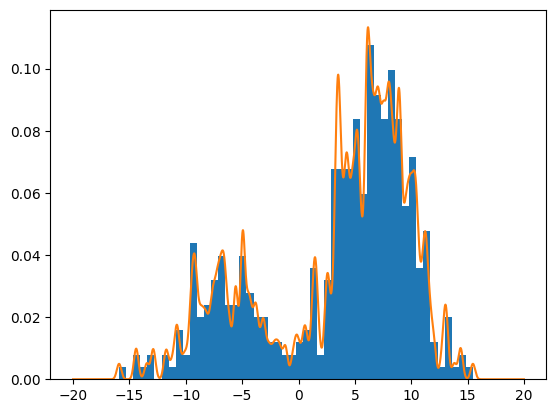

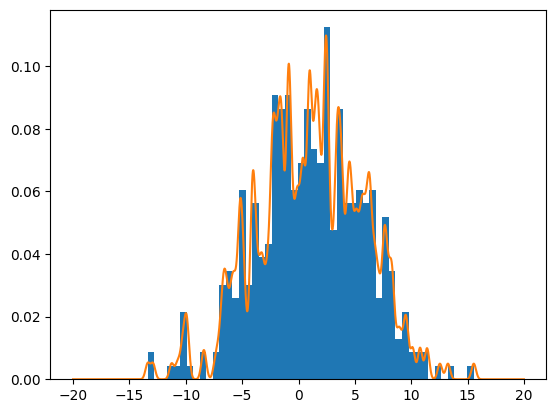

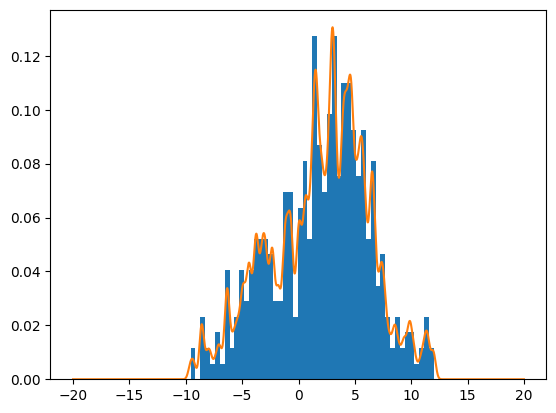

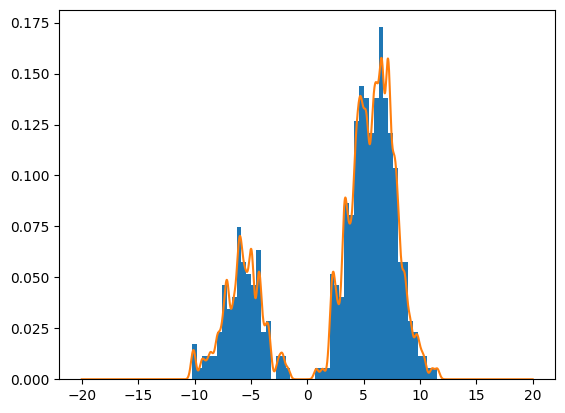

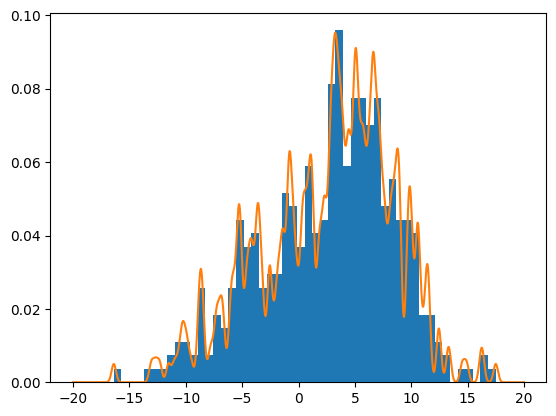

In [46]:
plt.hist(matrix_of_errors[:, 0], bins=50, density=True)       ## see probs instead of counts with density=True
plt.plot(x_EXAMPLE[:], pred_kde_gaus_probs[:,0])     ## reshaped to 2D
plt.show()

plt.hist(matrix_of_errors[:, 1], bins=50, density=True)       ## see probs instead of counts with density=True
plt.plot(x_EXAMPLE[:], pred_kde_gaus_probs[:,1])     ## reshaped to 2D
plt.show()

plt.hist(matrix_of_errors[:, 2], bins=50, density=True)       ## see probs instead of counts with density=True
plt.plot(x_EXAMPLE[:], pred_kde_gaus_probs[:,2])     ## reshaped to 2D
plt.show()

plt.hist(matrix_of_errors[:, 3], bins=50, density=True)       ## see probs instead of counts with density=True
plt.plot(x_EXAMPLE[:], pred_kde_gaus_probs[:,3])     ## reshaped to 2D
plt.show()

plt.hist(matrix_of_errors[:, 4], bins=50, density=True)       ## see probs instead of counts with density=True
plt.plot(x_EXAMPLE[:], pred_kde_gaus_probs[:,4])     ## reshaped to 2D
plt.show()

SHOULD ADD up to 100.0 (i.e. 1.0)

In [47]:
print(sum(pred_kde_gaus_probs[:,0]))
print(sum(pred_kde_gaus_probs[:,1]))
print(sum(pred_kde_gaus_probs[:,2]))
print(sum(pred_kde_gaus_probs[:,3]))
print(sum(pred_kde_gaus_probs[:,4]))

tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)


## Now the loss for unknown distributions for multi output vectors

In [48]:

def train_multiple_kernels_per_output(x, matrix_of_errors, bandwidth):
    
    basis_func_trained_list = []
    for i in range(  matrix_of_errors.shape[1]   ):
        basis_func_trained_list.append(    sum_of_basis_func( K, matrix_of_errors[:,i] ,  bandwidth)    ) 
        
        
    list_of_pred_dists = []
    for i in range(  matrix_of_errors.shape[1]   ):
        basis_func_trained = basis_func_trained_list[i]
        list_of_pred_dists.append(   basis_func_trained(x)       )

    
    ## probabilities_matrix = np.vstack(list_of_pred_dists).T
    ## probabilities_exp_matrix = exp(probabilities_matrix)
    
    pred_kde_gaus_probs = torch.stack(list_of_pred_dists).T
    return pred_kde_gaus_probs
  


In [49]:

## tensor.detach().numpy()

def print_errors_kdes(matrix_of_errors, x_EXAMPLE, pred_kde_gaus_probs):
    
    matrix_of_errors    = matrix_of_errors.detach().numpy()
    pred_kde_gaus_probs = pred_kde_gaus_probs.detach().numpy()
    
    plt.hist(matrix_of_errors[:, 0], bins=50, density=True)       ## see probs instead of counts with density=True
    plt.plot(x_EXAMPLE[:], pred_kde_gaus_probs[:,0])     ## reshaped to 2D
    plt.show()

    plt.hist(matrix_of_errors[:, 1], bins=50, density=True)       ## see probs instead of counts with density=True
    plt.plot(x_EXAMPLE[:], pred_kde_gaus_probs[:,1])     ## reshaped to 2D
    plt.show()

    plt.hist(matrix_of_errors[:, 2], bins=50, density=True)       ## see probs instead of counts with density=True
    plt.plot(x_EXAMPLE[:], pred_kde_gaus_probs[:,2])     ## reshaped to 2D
    plt.show()

    plt.hist(matrix_of_errors[:, 3], bins=50, density=True)       ## see probs instead of counts with density=True
    plt.plot(x_EXAMPLE[:], pred_kde_gaus_probs[:,3])     ## reshaped to 2D
    plt.show()

    plt.hist(matrix_of_errors[:, 4], bins=50, density=True)       ## see probs instead of counts with density=True
    plt.plot(x_EXAMPLE[:], pred_kde_gaus_probs[:,4])     ## reshaped to 2D
    plt.show()


In [72]:
def my_loss_UNKNOWN_error_PDF(epoch, output, target):
    
    x = torch.arange(-N_error_range, N_error_range, 0.01)              ## 4000   ## the error is in this range 
    
    error = output.float() - target.float()                               ## 400 X 5
    
    impulseFunc = ImpulseGaussian(x, mean_impulse, std_impulse**2)        ## 4000 X 1
    
    basisFunc = train_multiple_kernels_per_output(x, error, bandwidth)    ## 4000 x 5
    
    if epoch % 50 == 0:
        print_errors_kdes(error, x, basisFunc)
        print(impulseFunc.shape)
        print(basisFunc.shape)
    
    basisFunc = basisFunc.T
    
   
    
    diff = ( basisFunc.float() -  impulseFunc.float()  )                 ## 4000 x 5
    
    
    
    loss = torch.mean(   (   diff  )**2    )   
    
    ## reg_sigma_func = (loss ** 2) * use_regularization
    ## loss = loss * ( 1.0 + reg_sigma_func )
    
    return loss

## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear

In [51]:
def print_individual_Rsquare(pred_descaled, y_test_tr):
    vector_pred_descaled = pred_descaled.detach().numpy()
    vector_y_test_tr     = y_test_tr.numpy()

    for i in range(len(output_indeces)):
        ## print(vector_pred_descaled.shape)
        print("*****")
        print("*****")
        print('Testing R**2 - Output: ' + str(i), r2_score( vector_pred_descaled[:, i], vector_y_test_tr[:, i] ) )
  

0  loss=  tensor(0.4709, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.0766, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.1451, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.0675, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.0820, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.2258, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.2068, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.2032, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.0805, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.1126, grad_fn=<MseLossBackward0>)
2000  loss=  tensor(0.1992, grad_fn=<MseLossBackward0>)
2200  loss=  tensor(0.1642, grad_fn=<MseLossBackward0>)
2400  loss=  tensor(0.1638, grad_fn=<MseLossBackward0>)
2600  loss=  tensor(0.0884, grad_fn=<MseLossBackward0>)
2800  loss=  tensor(0.1208, grad_fn=<MseLossBackward0>)
3000  loss=  tensor(0.0567, grad_fn=<MseLossBackward0>)
3200  loss=  tensor(0.1359, grad_fn=<MseLossBackward0>)
3400  loss=  tensor(0.2317, grad_fn=<MseLossBackward0>)

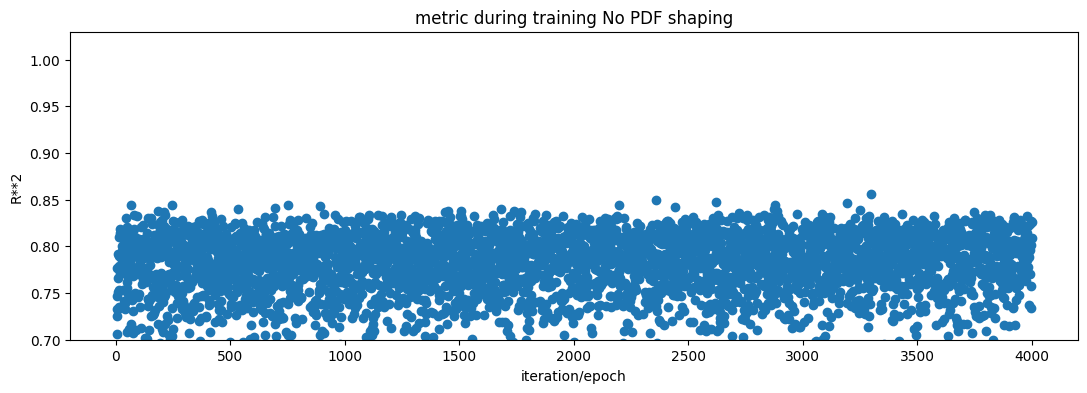

Training loss: tensor(0.1604, grad_fn=<MseLossBackward0>)
Training R**2: 0.7974145147477175
Test loss - scaled: tensor(0.1636, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(12283040., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.7801841575506105
Testing R**2 - descaled: 0.7801841620234311
*****
*****
Testing R**2 - Output: 0 0.4386820055607029
*****
*****
Testing R**2 - Output: 1 0.7577887684829443
*****
*****
Testing R**2 - Output: 2 0.8878569409216573
*****
*****
Testing R**2 - Output: 3 0.8393577518933861
*****
*****
Testing R**2 - Output: 4 0.9772353433371401


In [52]:

model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

print_individual_Rsquare(pred_descaled, y_test_tr)


## Use model to predict

In [53]:
list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(X_test_tr[i])
    ## print(  preds_descaled.shape  )
    ## print(  preds_descaled  )
    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = y_test_tr[i].detach().numpy()
    ## print(np_pred.shape)
    ## print(np_real.shape)

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])

**************************************************
preds, real
(49.383087, 49.20901)
(43.235718, 43.3349)
(90.52844, 98.137)
(137035.81, 141498.5)
(421.43103, 426.02496)
**************************************************
preds, real
(46.73377, 47.40926)
(43.002296, 43.87307)
(126.23335, 139.4571)
(147060.33, 146957.1)
(454.7971, 464.4875)
**************************************************
preds, real
(48.643456, 48.30868)
(42.60966, 41.75307)
(156.6936, 154.6595)
(127099.27, 116685.2)
(413.27954, 411.70374)
**************************************************
preds, real
(47.40317, 46.93355)
(40.88612, 40.0452)
(171.29633, 174.2383)
(137429.89, 135887.0)
(387.3619, 385.77145)
**************************************************
preds, real
(48.087658, 48.91765)
(42.131718, 41.95866)
(110.55444, 112.1872)
(132223.53, 128572.6)
(405.962, 405.5281)
**************************************************
preds, real
(46.97173, 47.06797)
(46.54432, 45.59747)
(87.36751, 86.5659)
(154917.25, 165876.7)

## Plotting

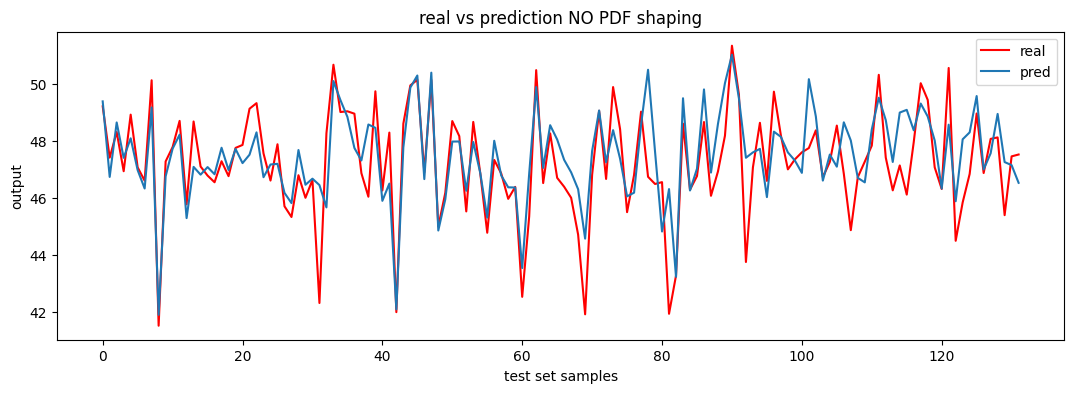

In [54]:
list_preds_y0 = [list_preds[i] for i in range(0, len(list_preds), 5)]
list_reals_y0 = [list_reals[i] for i in range(0, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y0, label= 'real', color='r' )
plt.plot(list_preds_y0, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y0ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

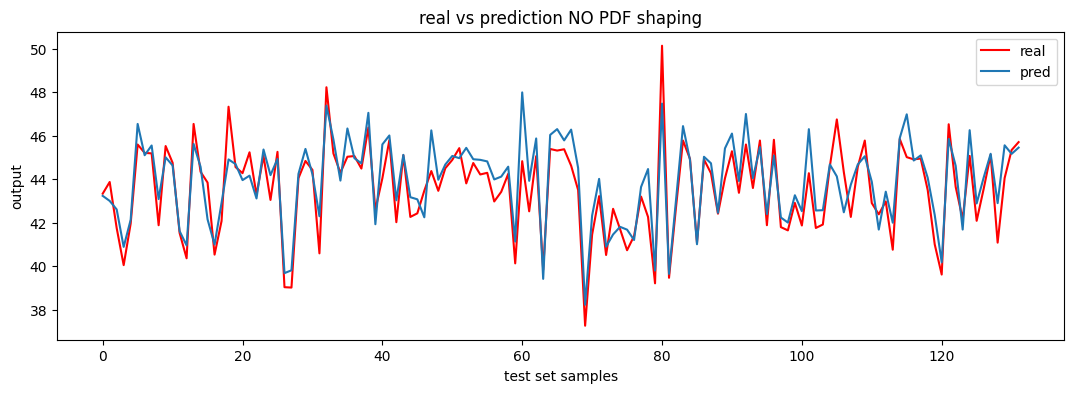

In [55]:
list_preds_y1 = [list_preds[i] for i in range(1, len(list_preds), 5)]
list_reals_y1 = [list_reals[i] for i in range(1, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y1, label= 'real', color='r' )
plt.plot(list_preds_y1, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y1ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

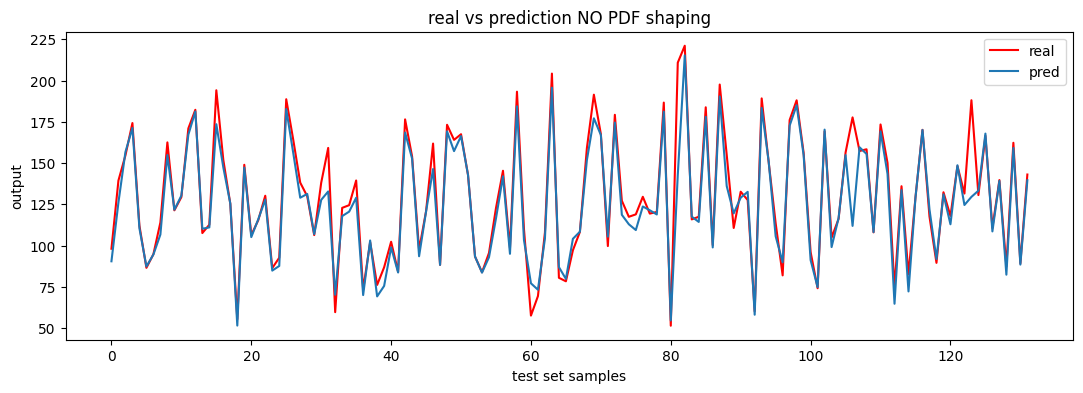

In [56]:
list_preds_y2 = [list_preds[i] for i in range(2, len(list_preds), 5)]
list_reals_y2 = [list_reals[i] for i in range(2, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y2, label= 'real', color='r' )
plt.plot(list_preds_y2, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y2ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

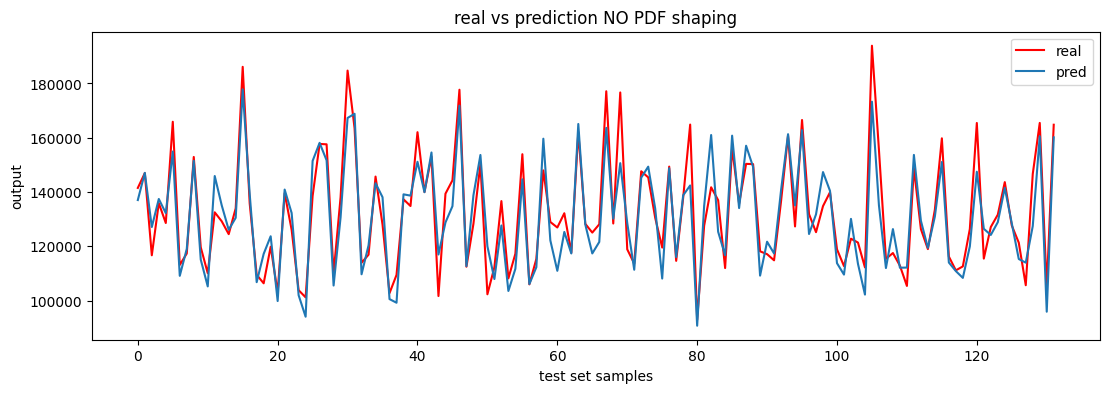

In [57]:
list_preds_y3 = [list_preds[i] for i in range(3, len(list_preds), 5)]
list_reals_y3 = [list_reals[i] for i in range(3, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y3, label= 'real', color='r' )
plt.plot(list_preds_y3, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y3ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

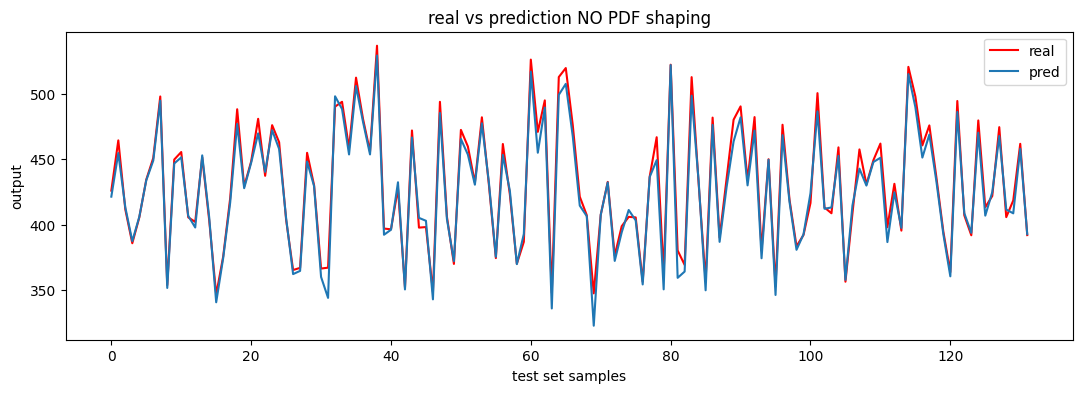

In [58]:
list_preds_y4 = [list_preds[i] for i in range(4, len(list_preds), 5)]
list_reals_y4 = [list_reals[i] for i in range(4, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y4, label= 'real', color='r' )
plt.plot(list_preds_y4, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y4ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


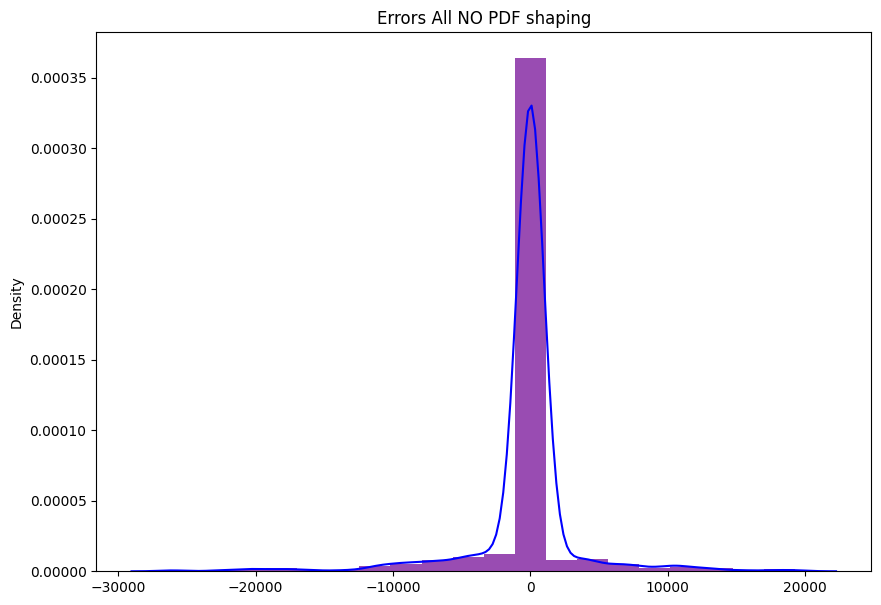

In [59]:
n_bins = 20

y_pred = np.array(list_preds)

y_real = np.array(list_reals)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error,     bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title('Errors All NO PDF shaping')


plt.show()

/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


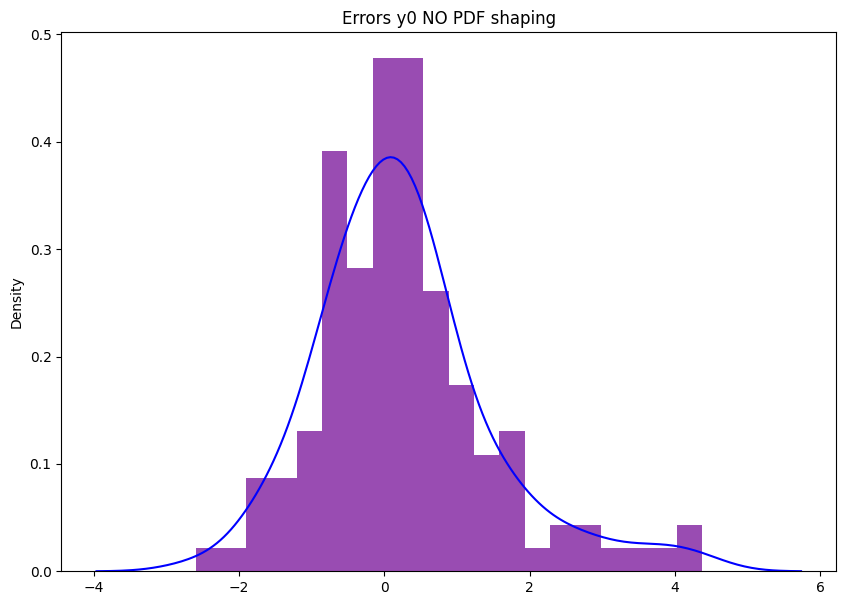

In [60]:
n_bins = 20

y_pred = np.array(list_preds_y0)

y_real = np.array(list_reals_y0)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title('Errors y0 NO PDF shaping')


plt.show()

/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


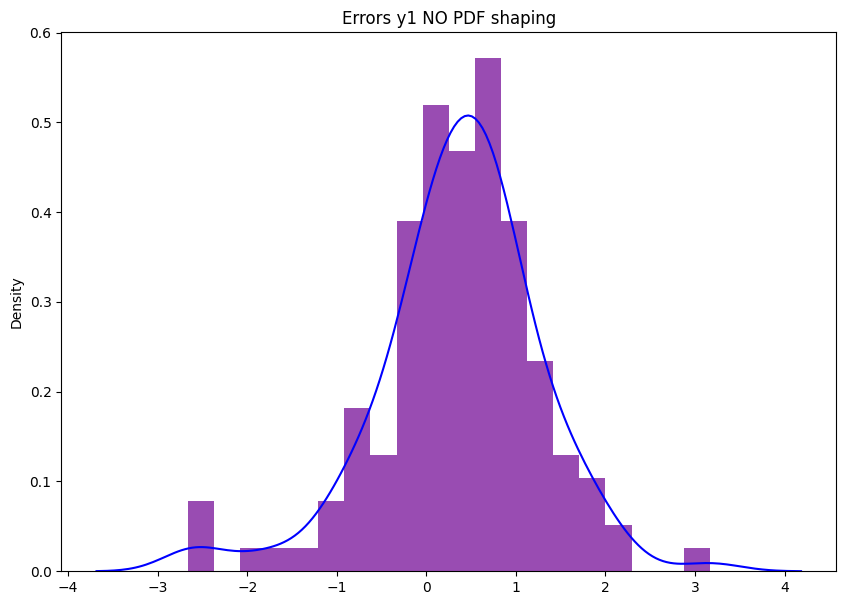

In [61]:
n_bins = 20

y_pred = np.array(list_preds_y1)

y_real = np.array(list_reals_y1)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title('Errors y1 NO PDF shaping')


plt.show()

/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


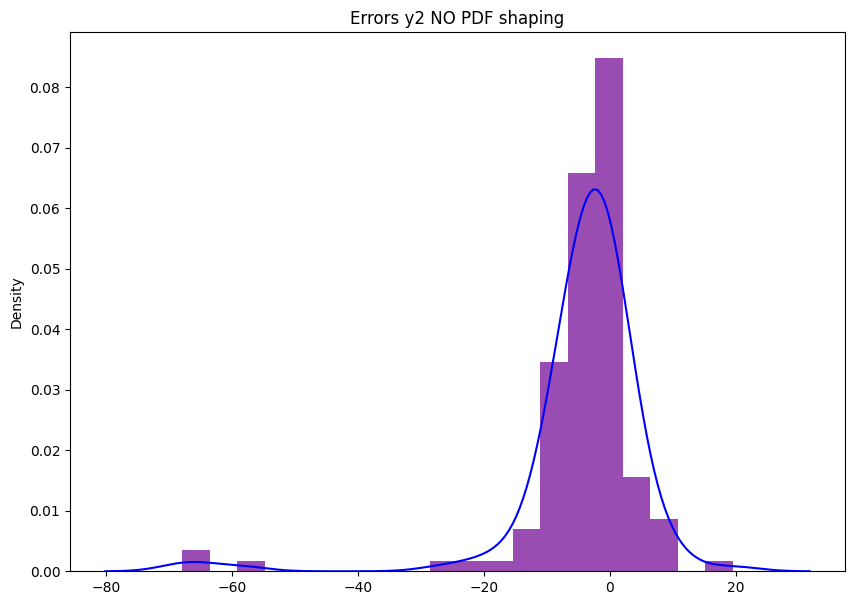

In [62]:
n_bins = 20

y_pred = np.array(list_preds_y2)

y_real = np.array(list_reals_y2)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")


plt.title('Errors y2 NO PDF shaping')


plt.show()

/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


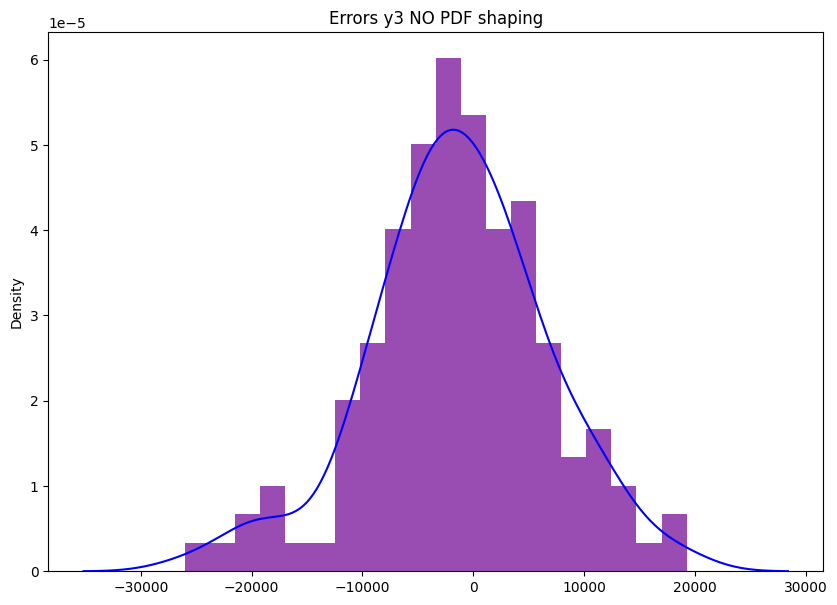

In [63]:
n_bins = 20

y_pred = np.array(list_preds_y3)

y_real = np.array(list_reals_y3)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")


plt.title('Errors y3 NO PDF shaping')


plt.show()

/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


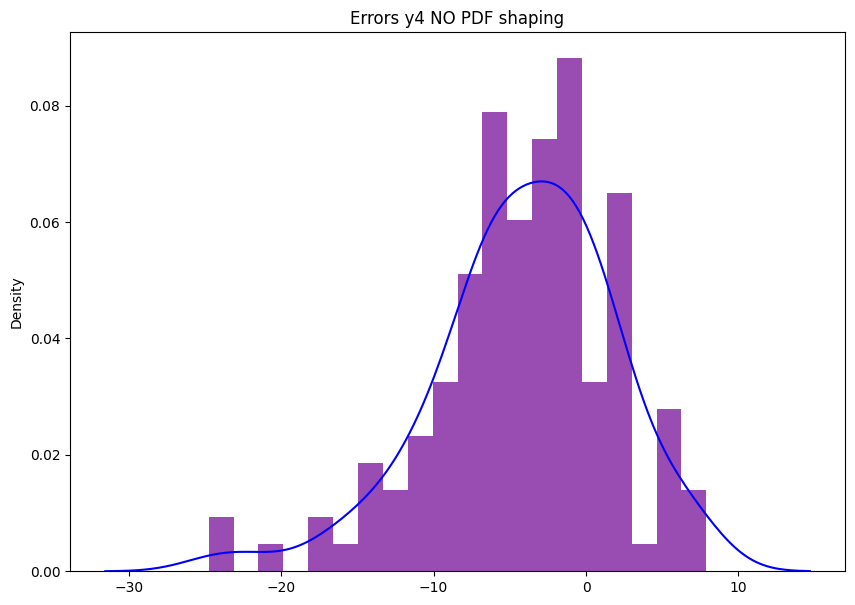

In [64]:
n_bins = 20

y_pred = np.array(list_preds_y4)

y_real = np.array(list_reals_y4)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title('Errors y4 NO PDF shaping')


plt.show()

## Results for g(x) = F1(x) + F2(x) with PDF shaping

F1 = Linear

F2 = Nonlinear

In [75]:
def print_individual_Rsquare(pred_descaled, y_test_tr):
    vector_pred_descaled = pred_descaled.detach().numpy()
    vector_y_test_tr     = y_test_tr.numpy()

    for i in range(len(output_indeces)):
        ## print(vector_pred_descaled.shape)
        print("*****")
        print("*****")
        print('Testing R**2 - Output: ' + str(i), r2_score( vector_pred_descaled[:, i], vector_y_test_tr[:, i] ) )
        

0  loss=  tensor(0.5576, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.1525, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.1451, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.1587, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.1069, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.1381, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.0687, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.1469, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.2734, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.1341, grad_fn=<MseLossBackward0>)
2000  loss=  tensor(0.0858, grad_fn=<MseLossBackward0>)
2200  loss=  tensor(0.2329, grad_fn=<MseLossBackward0>)
2400  loss=  tensor(0.1064, grad_fn=<MseLossBackward0>)
2600  loss=  tensor(0.1238, grad_fn=<MseLossBackward0>)
2800  loss=  tensor(0.1530, grad_fn=<MseLossBackward0>)
3000  loss=  tensor(0.2292, grad_fn=<MseLossBackward0>)
3200  loss=  tensor(0.1458, grad_fn=<MseLossBackward0>)
3400  loss=  tensor(0.1807, grad_fn=<MseLossBackward0>)

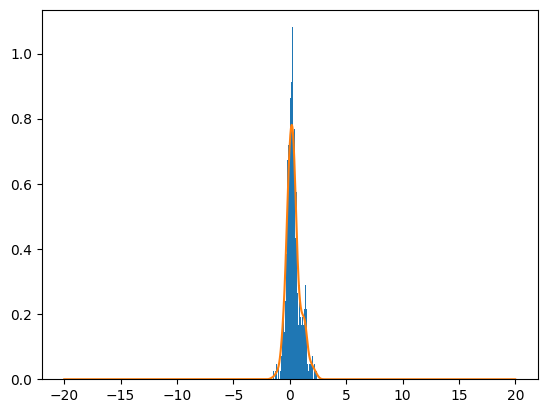

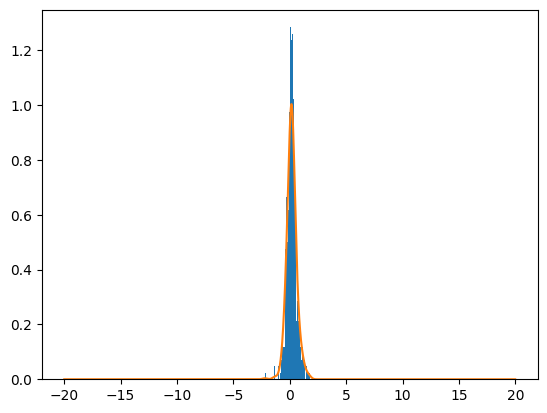

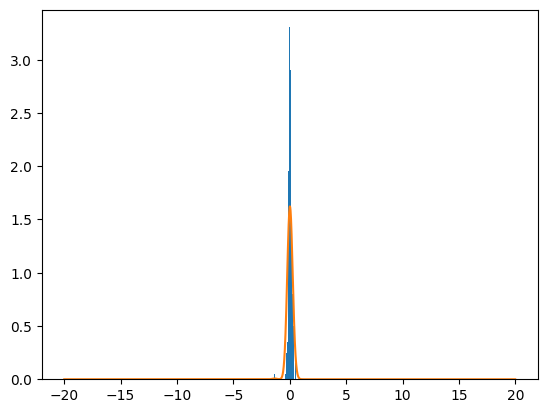

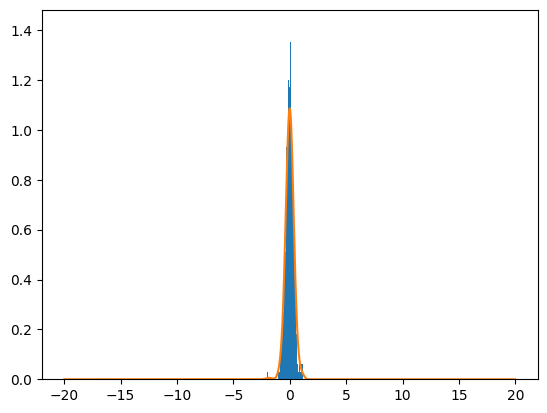

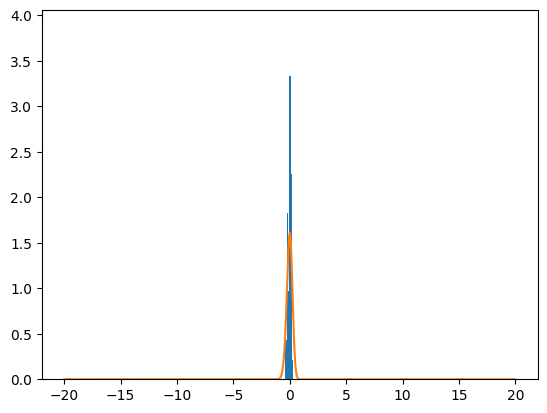

torch.Size([4000])
torch.Size([4000, 5])
0  loss=  tensor(0.6667, grad_fn=<MeanBackward0>)
1  loss=  tensor(0.6666, grad_fn=<MeanBackward0>)
2  loss=  tensor(0.6661, grad_fn=<MeanBackward0>)
3  loss=  tensor(0.6666, grad_fn=<MeanBackward0>)
4  loss=  tensor(0.6668, grad_fn=<MeanBackward0>)
5  loss=  tensor(0.6662, grad_fn=<MeanBackward0>)
6  loss=  tensor(0.6662, grad_fn=<MeanBackward0>)
7  loss=  tensor(0.6661, grad_fn=<MeanBackward0>)
8  loss=  tensor(0.6665, grad_fn=<MeanBackward0>)
9  loss=  tensor(0.6659, grad_fn=<MeanBackward0>)
10  loss=  tensor(0.6661, grad_fn=<MeanBackward0>)
11  loss=  tensor(0.6661, grad_fn=<MeanBackward0>)
12  loss=  tensor(0.6663, grad_fn=<MeanBackward0>)
13  loss=  tensor(0.6658, grad_fn=<MeanBackward0>)
14  loss=  tensor(0.6662, grad_fn=<MeanBackward0>)
15  loss=  tensor(0.6660, grad_fn=<MeanBackward0>)
16  loss=  tensor(0.6662, grad_fn=<MeanBackward0>)
17  loss=  tensor(0.6657, grad_fn=<MeanBackward0>)
18  loss=  tensor(0.6657, grad_fn=<MeanBackward0>)


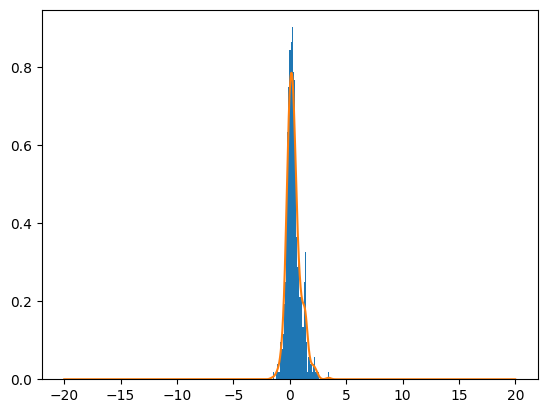

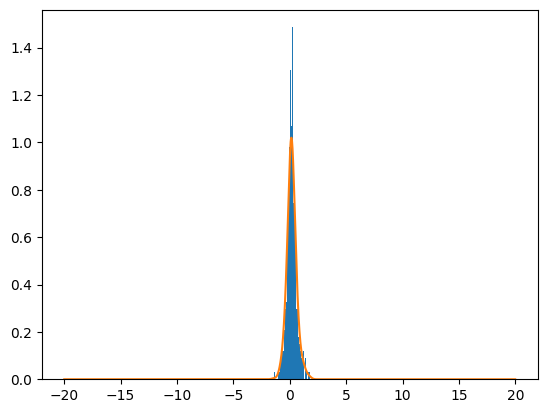

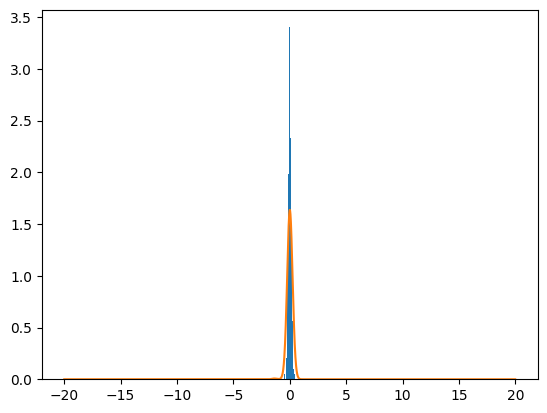

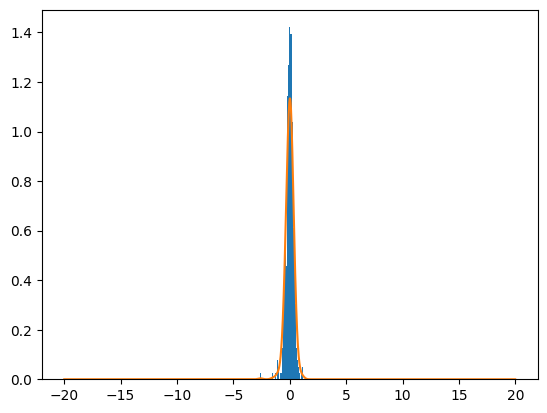

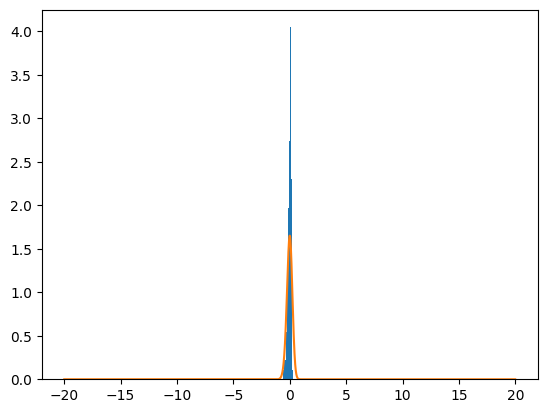

torch.Size([4000])
torch.Size([4000, 5])
50  loss=  tensor(0.6656, grad_fn=<MeanBackward0>)
51  loss=  tensor(0.6655, grad_fn=<MeanBackward0>)
52  loss=  tensor(0.6655, grad_fn=<MeanBackward0>)
53  loss=  tensor(0.6654, grad_fn=<MeanBackward0>)
54  loss=  tensor(0.6658, grad_fn=<MeanBackward0>)
55  loss=  tensor(0.6652, grad_fn=<MeanBackward0>)
56  loss=  tensor(0.6657, grad_fn=<MeanBackward0>)
57  loss=  tensor(0.6653, grad_fn=<MeanBackward0>)
58  loss=  tensor(0.6655, grad_fn=<MeanBackward0>)
59  loss=  tensor(0.6657, grad_fn=<MeanBackward0>)
60  loss=  tensor(0.6655, grad_fn=<MeanBackward0>)
61  loss=  tensor(0.6657, grad_fn=<MeanBackward0>)
62  loss=  tensor(0.6654, grad_fn=<MeanBackward0>)
63  loss=  tensor(0.6654, grad_fn=<MeanBackward0>)
64  loss=  tensor(0.6655, grad_fn=<MeanBackward0>)
65  loss=  tensor(0.6651, grad_fn=<MeanBackward0>)
66  loss=  tensor(0.6652, grad_fn=<MeanBackward0>)
67  loss=  tensor(0.6654, grad_fn=<MeanBackward0>)
68  loss=  tensor(0.6652, grad_fn=<MeanBa

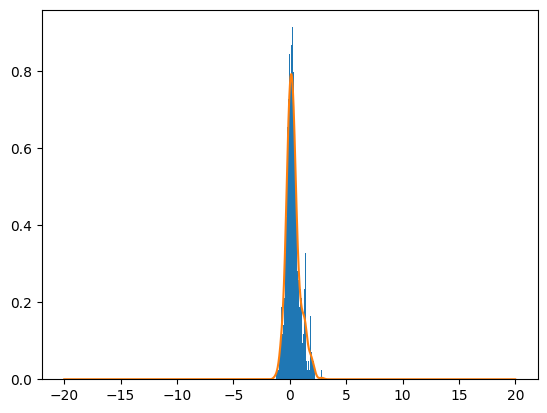

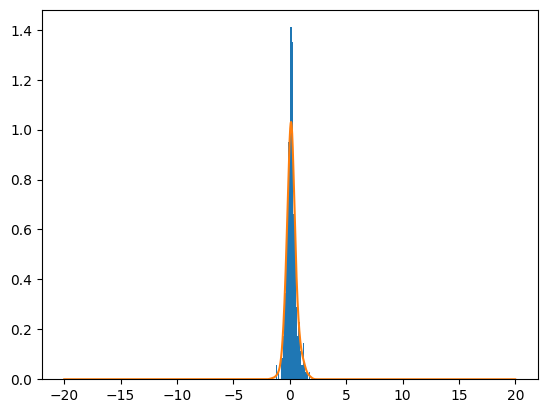

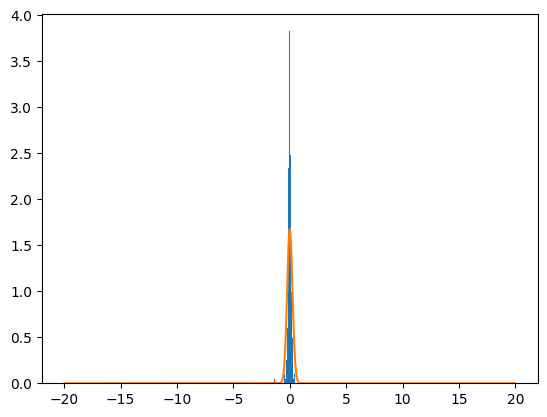

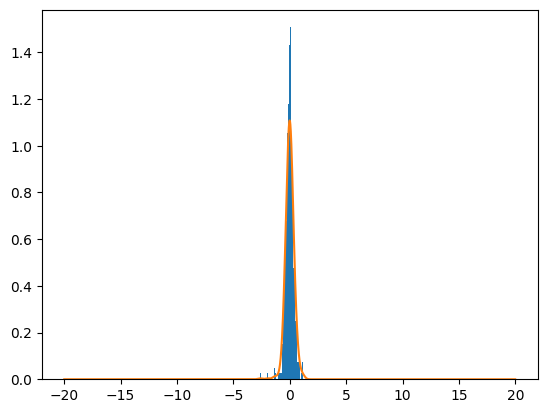

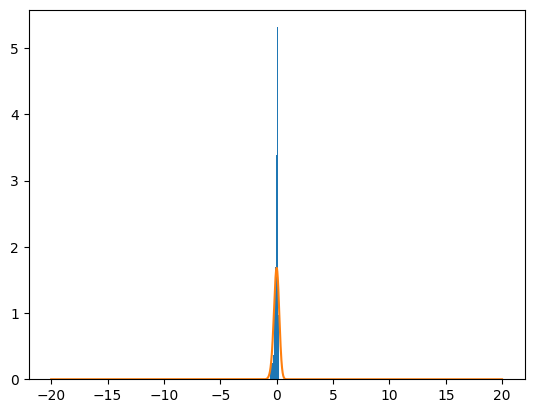

torch.Size([4000])
torch.Size([4000, 5])
100  loss=  tensor(0.6648, grad_fn=<MeanBackward0>)
101  loss=  tensor(0.6650, grad_fn=<MeanBackward0>)
102  loss=  tensor(0.6649, grad_fn=<MeanBackward0>)
103  loss=  tensor(0.6646, grad_fn=<MeanBackward0>)
104  loss=  tensor(0.6649, grad_fn=<MeanBackward0>)
105  loss=  tensor(0.6652, grad_fn=<MeanBackward0>)
106  loss=  tensor(0.6647, grad_fn=<MeanBackward0>)
107  loss=  tensor(0.6648, grad_fn=<MeanBackward0>)
108  loss=  tensor(0.6646, grad_fn=<MeanBackward0>)
109  loss=  tensor(0.6646, grad_fn=<MeanBackward0>)
110  loss=  tensor(0.6644, grad_fn=<MeanBackward0>)
111  loss=  tensor(0.6651, grad_fn=<MeanBackward0>)
112  loss=  tensor(0.6648, grad_fn=<MeanBackward0>)
113  loss=  tensor(0.6647, grad_fn=<MeanBackward0>)
114  loss=  tensor(0.6647, grad_fn=<MeanBackward0>)
115  loss=  tensor(0.6645, grad_fn=<MeanBackward0>)
116  loss=  tensor(0.6649, grad_fn=<MeanBackward0>)
117  loss=  tensor(0.6649, grad_fn=<MeanBackward0>)
118  loss=  tensor(0.66

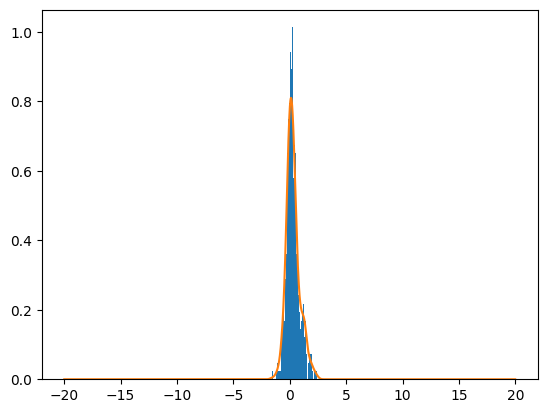

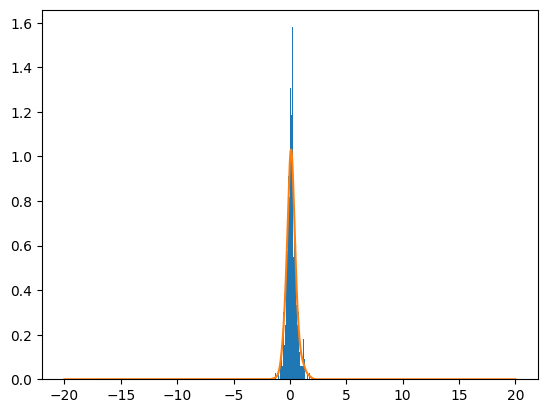

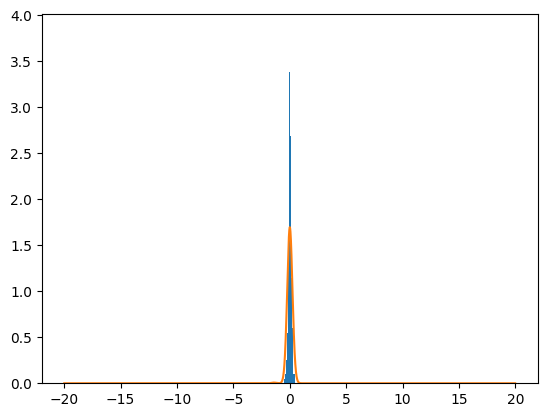

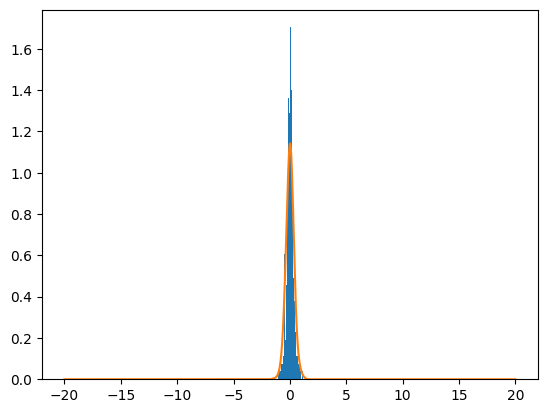

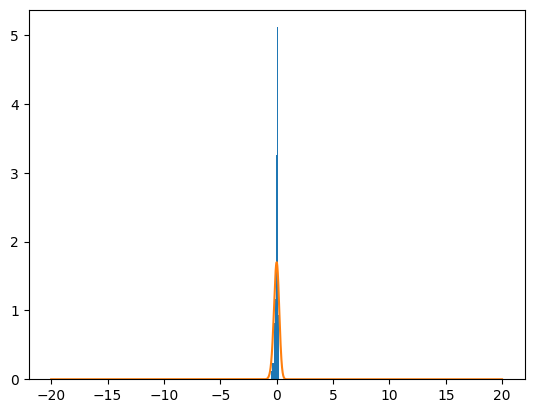

torch.Size([4000])
torch.Size([4000, 5])
150  loss=  tensor(0.6640, grad_fn=<MeanBackward0>)
151  loss=  tensor(0.6645, grad_fn=<MeanBackward0>)
152  loss=  tensor(0.6638, grad_fn=<MeanBackward0>)
153  loss=  tensor(0.6644, grad_fn=<MeanBackward0>)
154  loss=  tensor(0.6643, grad_fn=<MeanBackward0>)
155  loss=  tensor(0.6643, grad_fn=<MeanBackward0>)
156  loss=  tensor(0.6639, grad_fn=<MeanBackward0>)
157  loss=  tensor(0.6643, grad_fn=<MeanBackward0>)
158  loss=  tensor(0.6642, grad_fn=<MeanBackward0>)
159  loss=  tensor(0.6641, grad_fn=<MeanBackward0>)
160  loss=  tensor(0.6644, grad_fn=<MeanBackward0>)
161  loss=  tensor(0.6640, grad_fn=<MeanBackward0>)
162  loss=  tensor(0.6644, grad_fn=<MeanBackward0>)
163  loss=  tensor(0.6636, grad_fn=<MeanBackward0>)
164  loss=  tensor(0.6643, grad_fn=<MeanBackward0>)
165  loss=  tensor(0.6642, grad_fn=<MeanBackward0>)
166  loss=  tensor(0.6642, grad_fn=<MeanBackward0>)
167  loss=  tensor(0.6640, grad_fn=<MeanBackward0>)
168  loss=  tensor(0.66

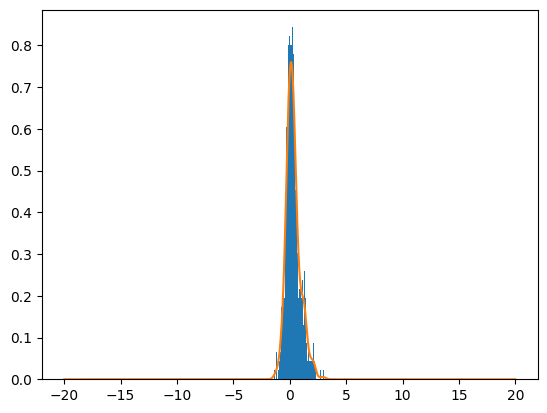

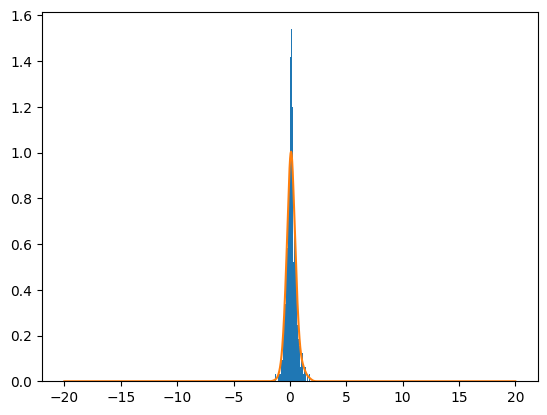

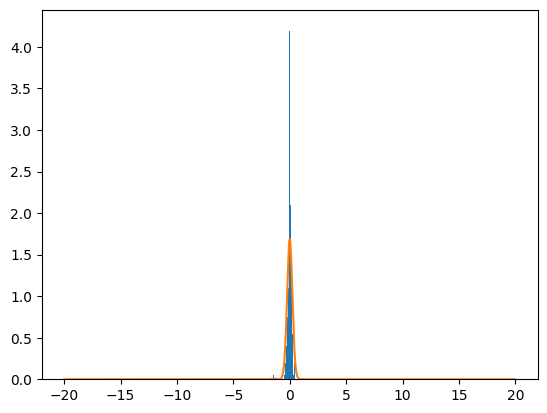

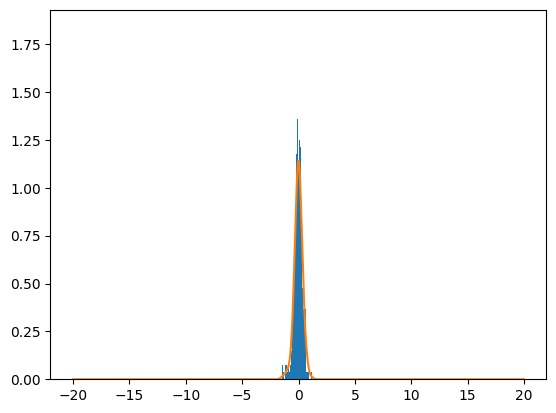

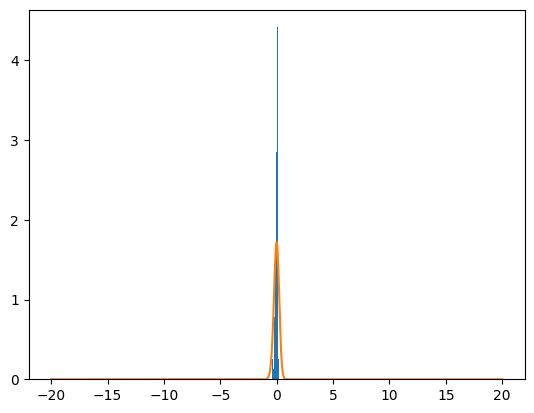

torch.Size([4000])
torch.Size([4000, 5])
200  loss=  tensor(0.6644, grad_fn=<MeanBackward0>)
201  loss=  tensor(0.6636, grad_fn=<MeanBackward0>)
202  loss=  tensor(0.6633, grad_fn=<MeanBackward0>)
203  loss=  tensor(0.6636, grad_fn=<MeanBackward0>)
204  loss=  tensor(0.6639, grad_fn=<MeanBackward0>)
205  loss=  tensor(0.6639, grad_fn=<MeanBackward0>)
206  loss=  tensor(0.6632, grad_fn=<MeanBackward0>)
207  loss=  tensor(0.6638, grad_fn=<MeanBackward0>)
208  loss=  tensor(0.6636, grad_fn=<MeanBackward0>)
209  loss=  tensor(0.6637, grad_fn=<MeanBackward0>)
210  loss=  tensor(0.6638, grad_fn=<MeanBackward0>)
211  loss=  tensor(0.6639, grad_fn=<MeanBackward0>)
212  loss=  tensor(0.6635, grad_fn=<MeanBackward0>)
213  loss=  tensor(0.6635, grad_fn=<MeanBackward0>)
214  loss=  tensor(0.6637, grad_fn=<MeanBackward0>)
215  loss=  tensor(0.6639, grad_fn=<MeanBackward0>)
216  loss=  tensor(0.6639, grad_fn=<MeanBackward0>)
217  loss=  tensor(0.6640, grad_fn=<MeanBackward0>)
218  loss=  tensor(0.66

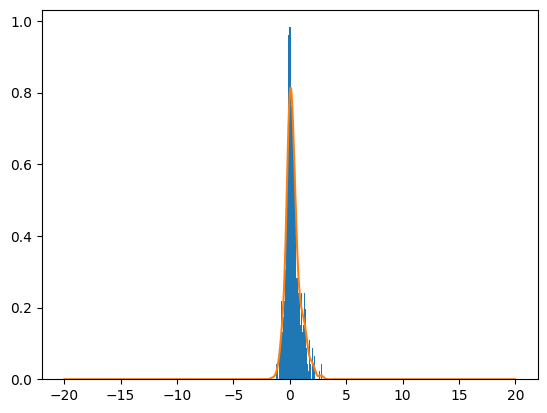

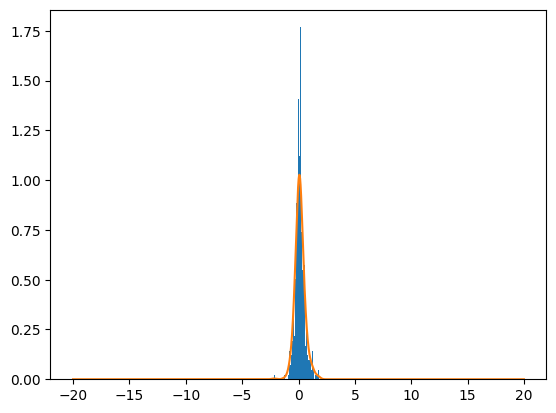

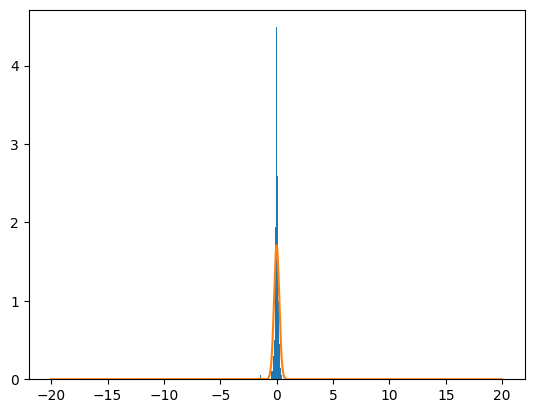

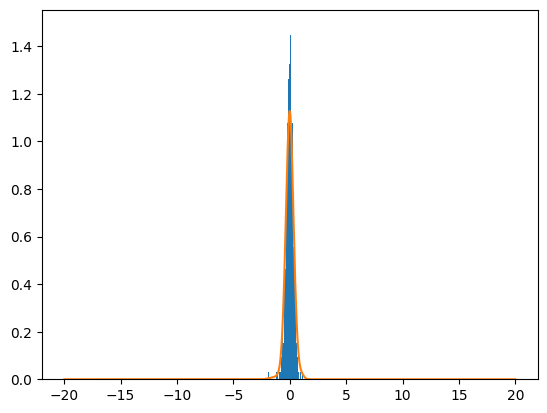

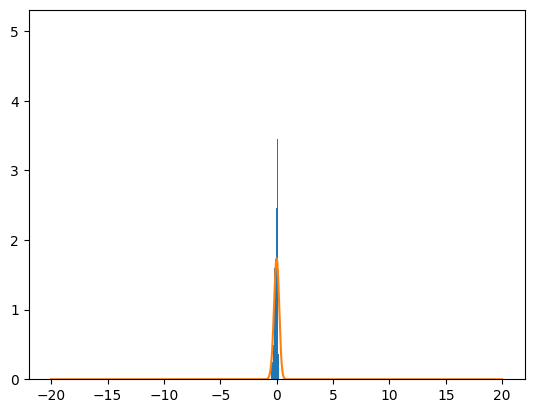

torch.Size([4000])
torch.Size([4000, 5])
250  loss=  tensor(0.6634, grad_fn=<MeanBackward0>)
251  loss=  tensor(0.6634, grad_fn=<MeanBackward0>)
252  loss=  tensor(0.6631, grad_fn=<MeanBackward0>)
253  loss=  tensor(0.6631, grad_fn=<MeanBackward0>)
254  loss=  tensor(0.6633, grad_fn=<MeanBackward0>)
255  loss=  tensor(0.6638, grad_fn=<MeanBackward0>)
256  loss=  tensor(0.6633, grad_fn=<MeanBackward0>)
257  loss=  tensor(0.6632, grad_fn=<MeanBackward0>)
258  loss=  tensor(0.6629, grad_fn=<MeanBackward0>)
259  loss=  tensor(0.6632, grad_fn=<MeanBackward0>)
260  loss=  tensor(0.6633, grad_fn=<MeanBackward0>)
261  loss=  tensor(0.6631, grad_fn=<MeanBackward0>)
262  loss=  tensor(0.6632, grad_fn=<MeanBackward0>)
263  loss=  tensor(0.6630, grad_fn=<MeanBackward0>)
264  loss=  tensor(0.6633, grad_fn=<MeanBackward0>)
265  loss=  tensor(0.6629, grad_fn=<MeanBackward0>)
266  loss=  tensor(0.6632, grad_fn=<MeanBackward0>)
267  loss=  tensor(0.6631, grad_fn=<MeanBackward0>)
268  loss=  tensor(0.66

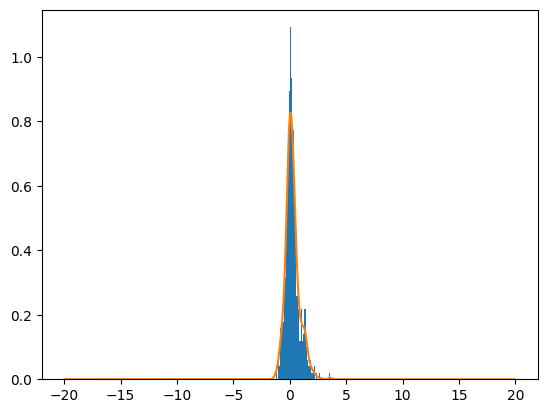

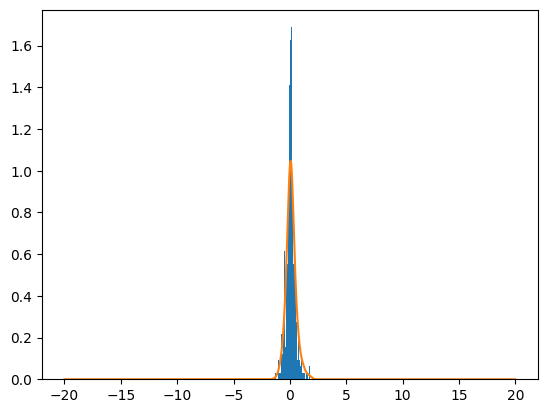

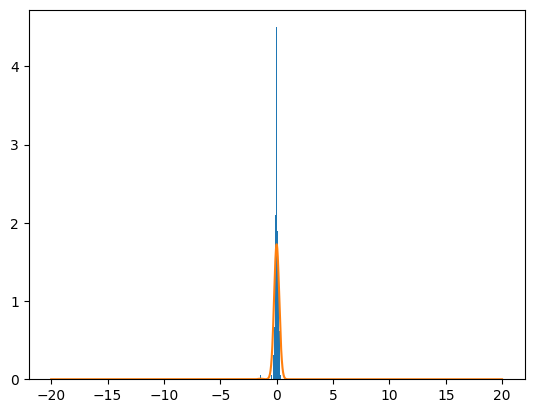

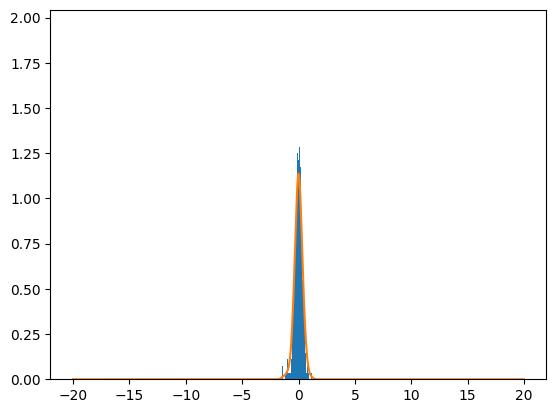

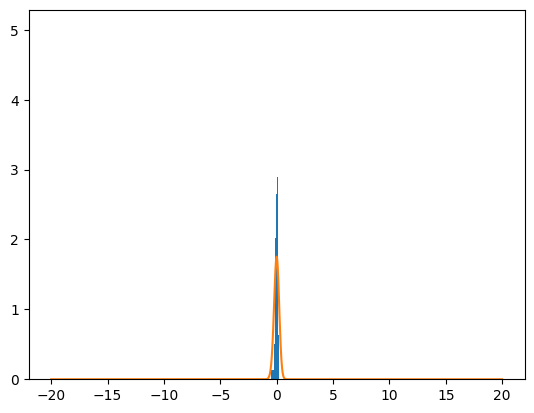

torch.Size([4000])
torch.Size([4000, 5])
300  loss=  tensor(0.6628, grad_fn=<MeanBackward0>)
301  loss=  tensor(0.6630, grad_fn=<MeanBackward0>)
302  loss=  tensor(0.6626, grad_fn=<MeanBackward0>)
303  loss=  tensor(0.6629, grad_fn=<MeanBackward0>)
304  loss=  tensor(0.6628, grad_fn=<MeanBackward0>)
305  loss=  tensor(0.6631, grad_fn=<MeanBackward0>)
306  loss=  tensor(0.6631, grad_fn=<MeanBackward0>)
307  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
308  loss=  tensor(0.6630, grad_fn=<MeanBackward0>)
309  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
310  loss=  tensor(0.6625, grad_fn=<MeanBackward0>)
311  loss=  tensor(0.6630, grad_fn=<MeanBackward0>)
312  loss=  tensor(0.6629, grad_fn=<MeanBackward0>)
313  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
314  loss=  tensor(0.6629, grad_fn=<MeanBackward0>)
315  loss=  tensor(0.6629, grad_fn=<MeanBackward0>)
316  loss=  tensor(0.6629, grad_fn=<MeanBackward0>)
317  loss=  tensor(0.6628, grad_fn=<MeanBackward0>)
318  loss=  tensor(0.66

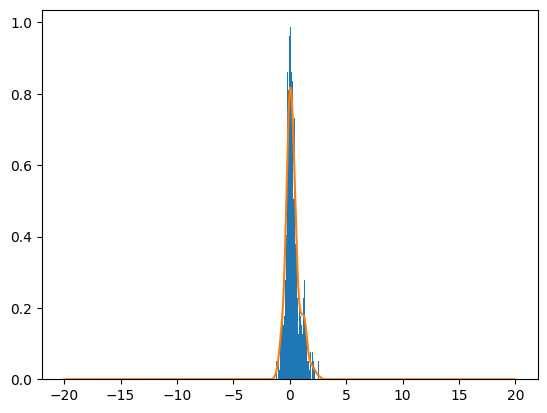

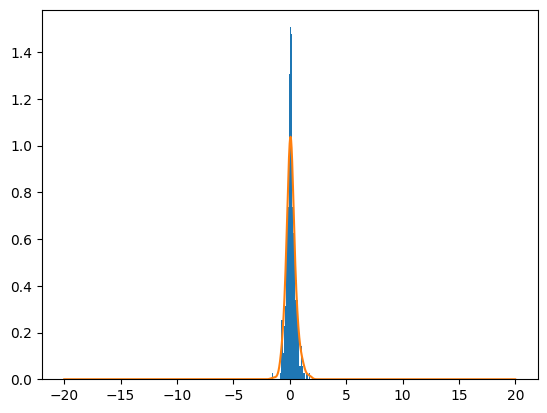

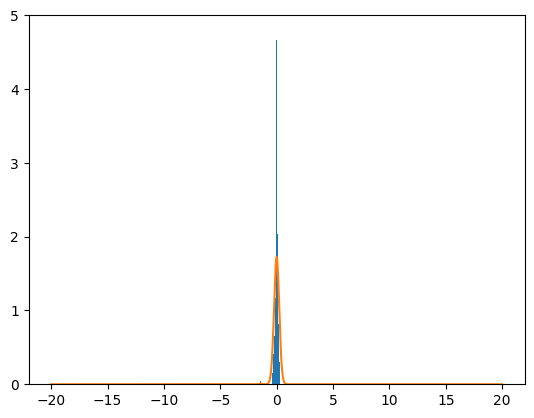

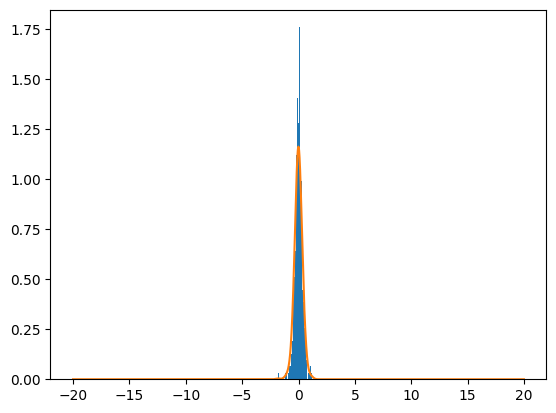

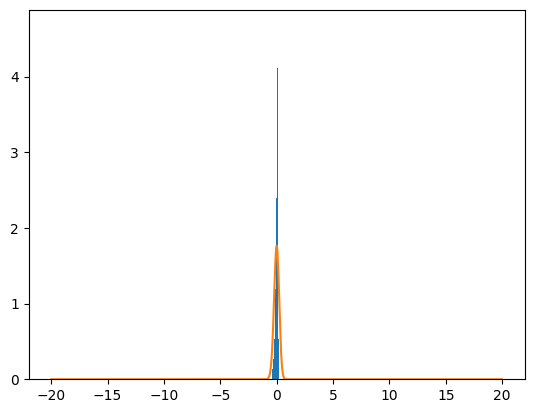

torch.Size([4000])
torch.Size([4000, 5])
350  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
351  loss=  tensor(0.6629, grad_fn=<MeanBackward0>)
352  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
353  loss=  tensor(0.6630, grad_fn=<MeanBackward0>)
354  loss=  tensor(0.6625, grad_fn=<MeanBackward0>)
355  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
356  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
357  loss=  tensor(0.6626, grad_fn=<MeanBackward0>)
358  loss=  tensor(0.6626, grad_fn=<MeanBackward0>)
359  loss=  tensor(0.6626, grad_fn=<MeanBackward0>)
360  loss=  tensor(0.6625, grad_fn=<MeanBackward0>)
361  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
362  loss=  tensor(0.6626, grad_fn=<MeanBackward0>)
363  loss=  tensor(0.6630, grad_fn=<MeanBackward0>)
364  loss=  tensor(0.6626, grad_fn=<MeanBackward0>)
365  loss=  tensor(0.6629, grad_fn=<MeanBackward0>)
366  loss=  tensor(0.6625, grad_fn=<MeanBackward0>)
367  loss=  tensor(0.6624, grad_fn=<MeanBackward0>)
368  loss=  tensor(0.66

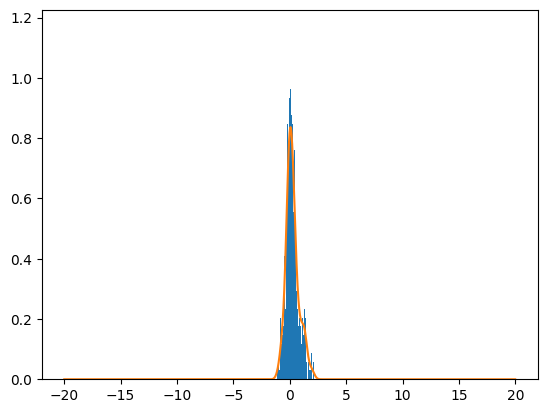

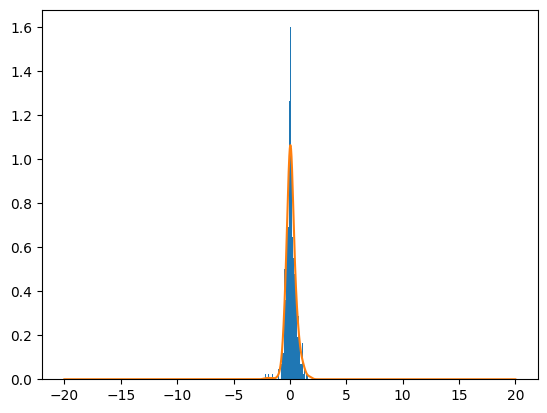

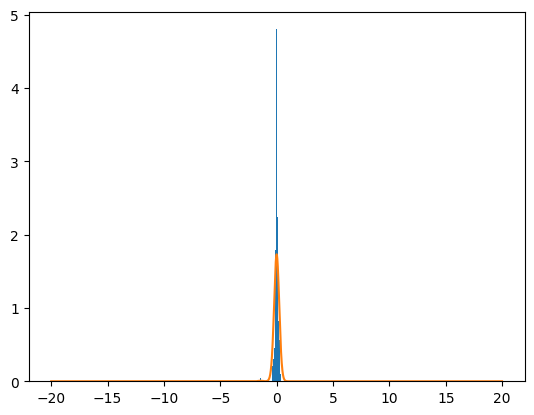

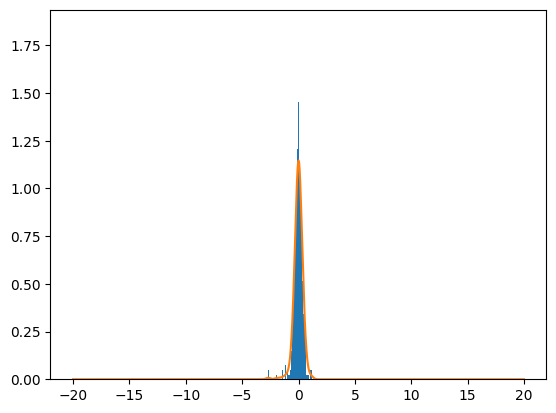

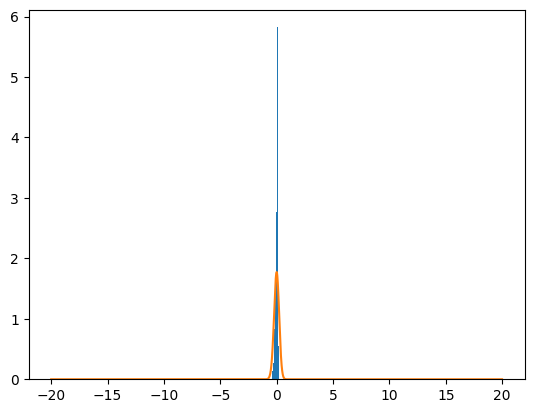

torch.Size([4000])
torch.Size([4000, 5])
400  loss=  tensor(0.6623, grad_fn=<MeanBackward0>)
401  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
402  loss=  tensor(0.6626, grad_fn=<MeanBackward0>)
403  loss=  tensor(0.6623, grad_fn=<MeanBackward0>)
404  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
405  loss=  tensor(0.6628, grad_fn=<MeanBackward0>)
406  loss=  tensor(0.6624, grad_fn=<MeanBackward0>)
407  loss=  tensor(0.6626, grad_fn=<MeanBackward0>)
408  loss=  tensor(0.6625, grad_fn=<MeanBackward0>)
409  loss=  tensor(0.6622, grad_fn=<MeanBackward0>)
410  loss=  tensor(0.6621, grad_fn=<MeanBackward0>)
411  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
412  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
413  loss=  tensor(0.6627, grad_fn=<MeanBackward0>)
414  loss=  tensor(0.6623, grad_fn=<MeanBackward0>)
415  loss=  tensor(0.6625, grad_fn=<MeanBackward0>)
416  loss=  tensor(0.6624, grad_fn=<MeanBackward0>)
417  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
418  loss=  tensor(0.66

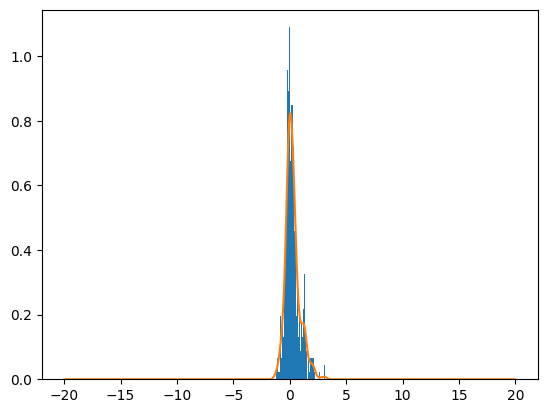

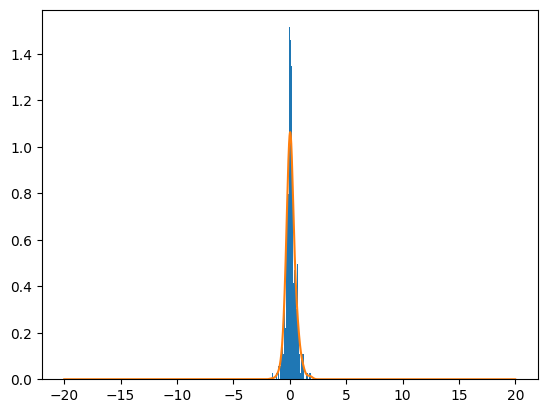

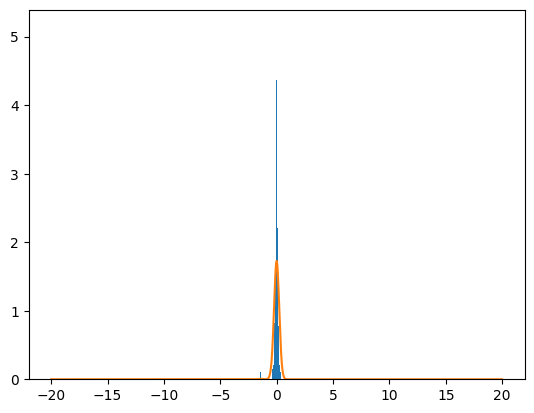

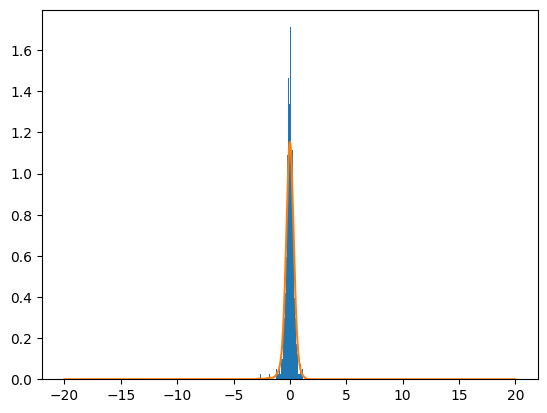

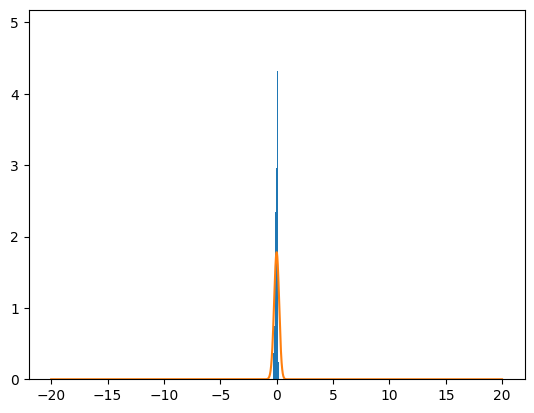

torch.Size([4000])
torch.Size([4000, 5])
450  loss=  tensor(0.6622, grad_fn=<MeanBackward0>)
451  loss=  tensor(0.6622, grad_fn=<MeanBackward0>)
452  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
453  loss=  tensor(0.6624, grad_fn=<MeanBackward0>)
454  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
455  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
456  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
457  loss=  tensor(0.6624, grad_fn=<MeanBackward0>)
458  loss=  tensor(0.6623, grad_fn=<MeanBackward0>)
459  loss=  tensor(0.6625, grad_fn=<MeanBackward0>)
460  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
461  loss=  tensor(0.6626, grad_fn=<MeanBackward0>)
462  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
463  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
464  loss=  tensor(0.6628, grad_fn=<MeanBackward0>)
465  loss=  tensor(0.6622, grad_fn=<MeanBackward0>)
466  loss=  tensor(0.6621, grad_fn=<MeanBackward0>)
467  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
468  loss=  tensor(0.66

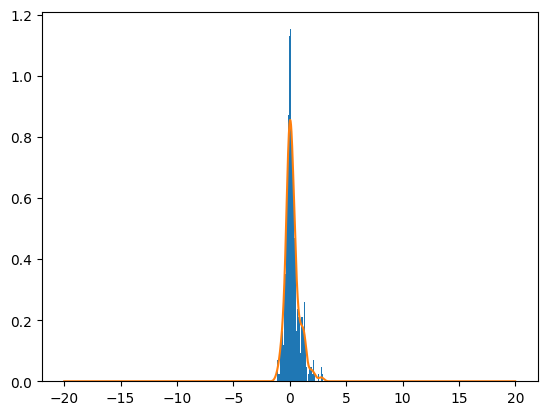

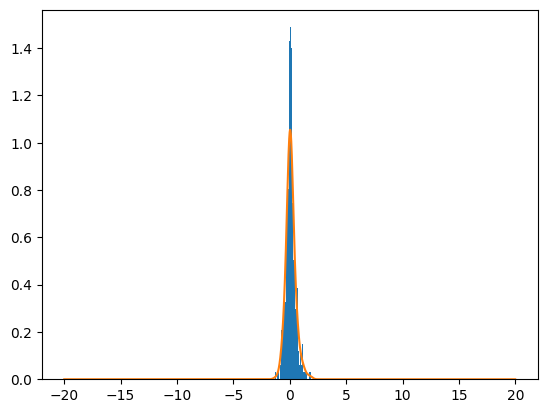

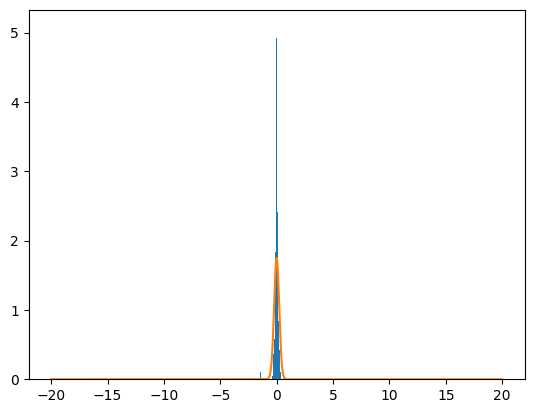

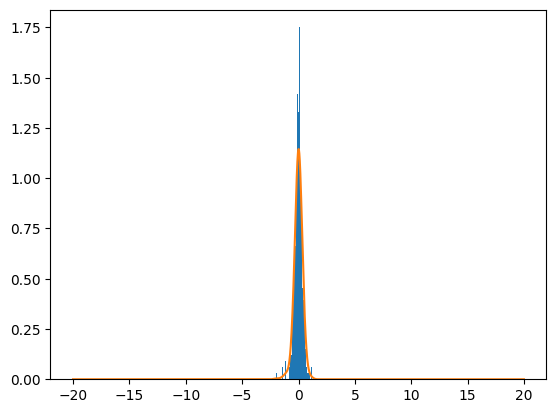

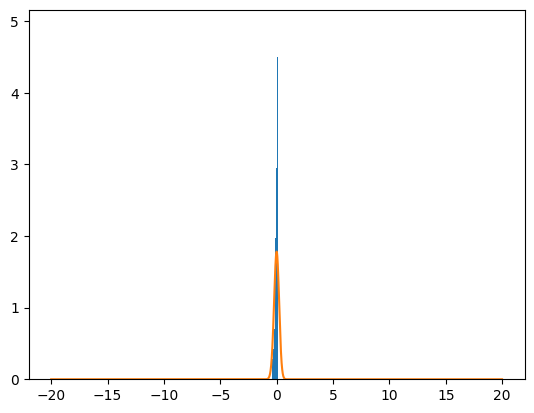

torch.Size([4000])
torch.Size([4000, 5])
500  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
501  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
502  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
503  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
504  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
505  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
506  loss=  tensor(0.6621, grad_fn=<MeanBackward0>)
507  loss=  tensor(0.6621, grad_fn=<MeanBackward0>)
508  loss=  tensor(0.6625, grad_fn=<MeanBackward0>)
509  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
510  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
511  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
512  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
513  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
514  loss=  tensor(0.6623, grad_fn=<MeanBackward0>)
515  loss=  tensor(0.6622, grad_fn=<MeanBackward0>)
516  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
517  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
518  loss=  tensor(0.66

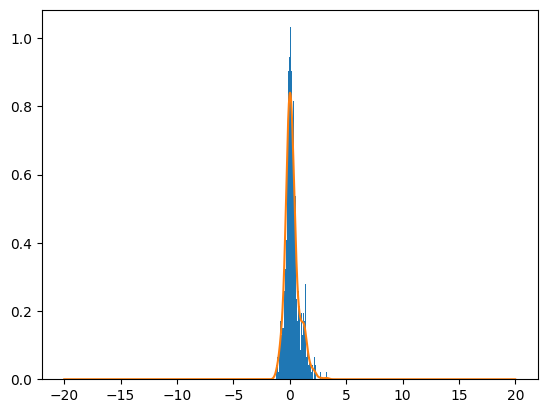

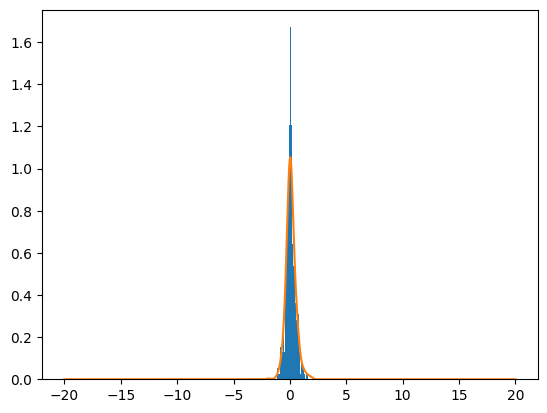

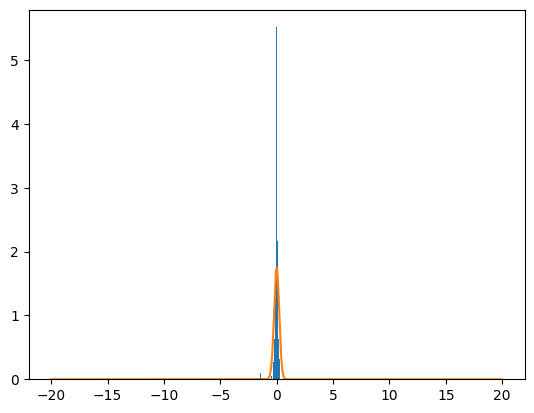

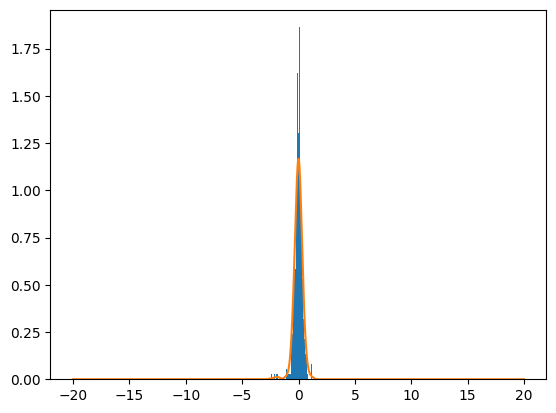

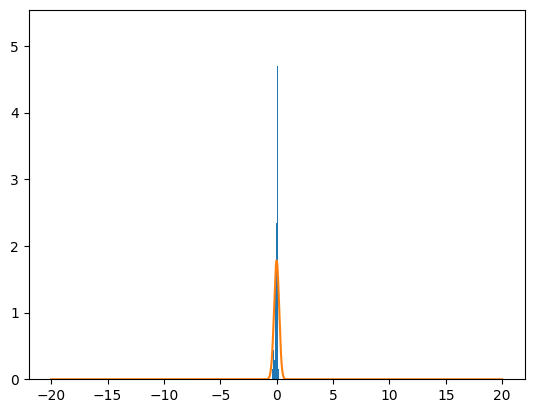

torch.Size([4000])
torch.Size([4000, 5])
550  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
551  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
552  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
553  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
554  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
555  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
556  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
557  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
558  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
559  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
560  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
561  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
562  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
563  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
564  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
565  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
566  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
567  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
568  loss=  tensor(0.66

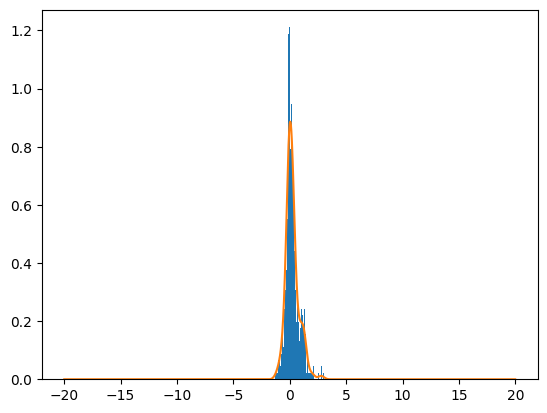

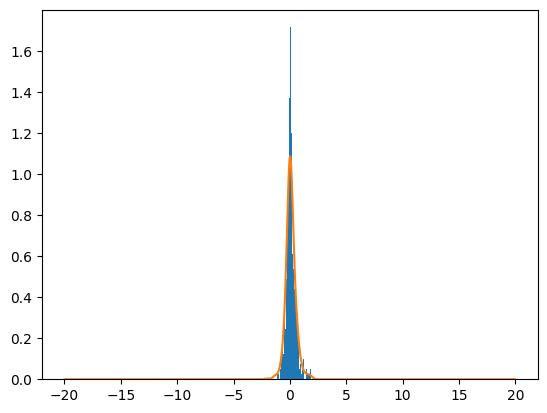

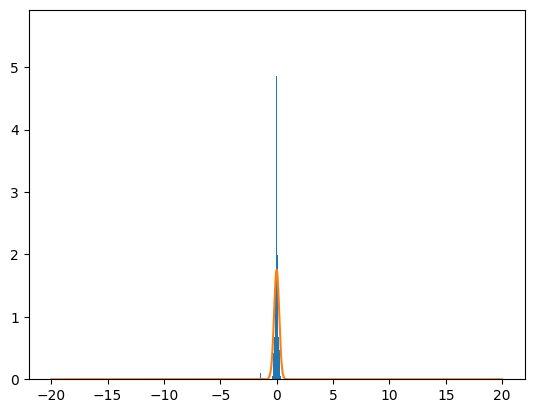

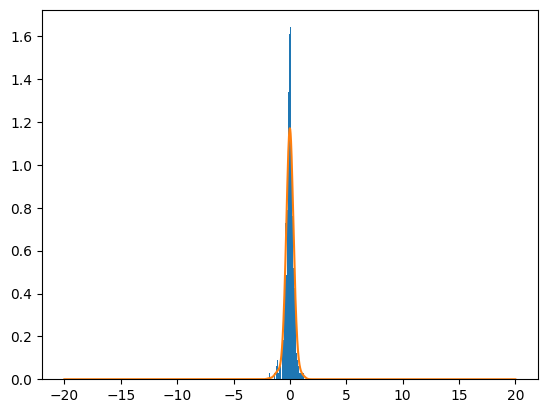

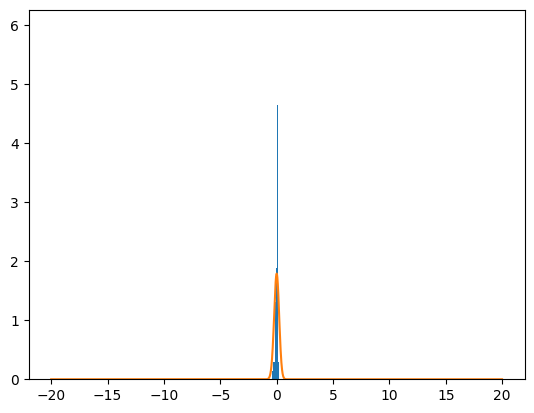

torch.Size([4000])
torch.Size([4000, 5])
600  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
601  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
602  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
603  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
604  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
605  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
606  loss=  tensor(0.6622, grad_fn=<MeanBackward0>)
607  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
608  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
609  loss=  tensor(0.6621, grad_fn=<MeanBackward0>)
610  loss=  tensor(0.6620, grad_fn=<MeanBackward0>)
611  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
612  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
613  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
614  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
615  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
616  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
617  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
618  loss=  tensor(0.66

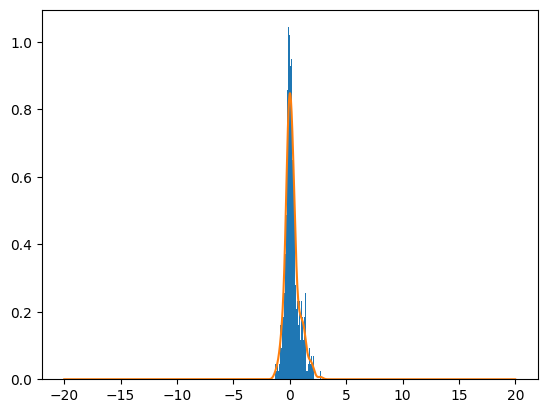

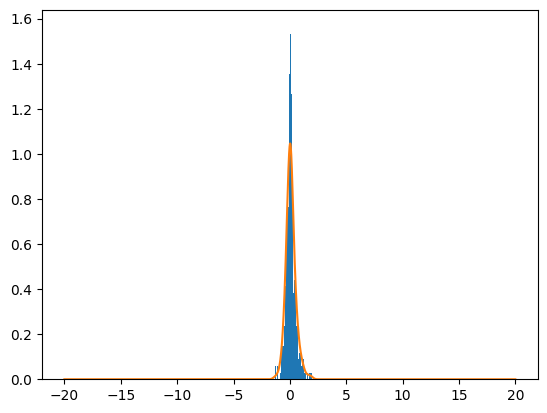

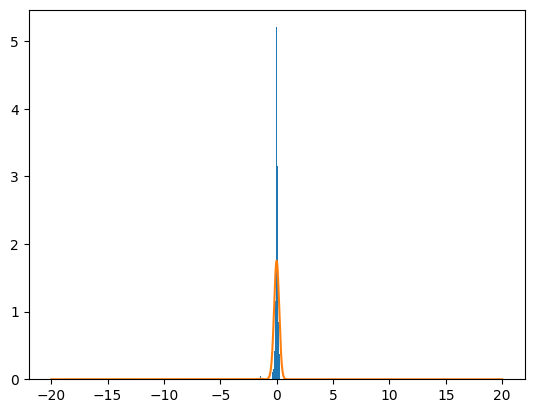

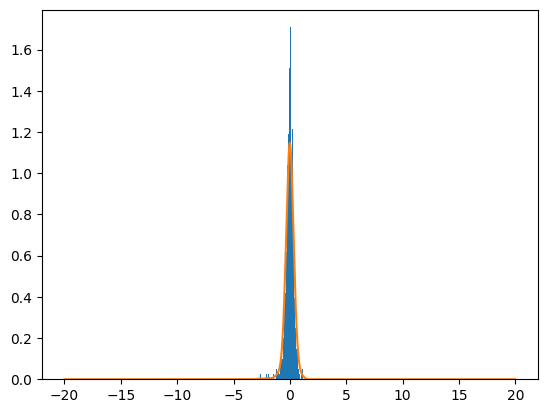

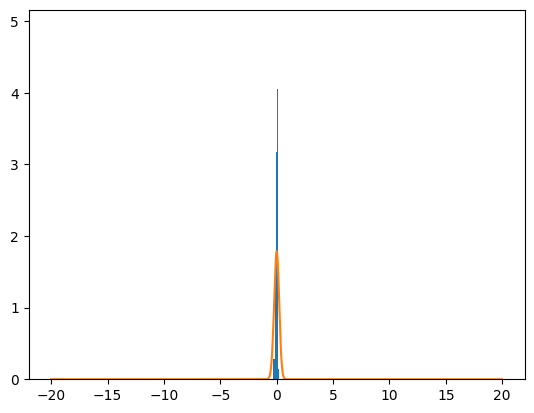

torch.Size([4000])
torch.Size([4000, 5])
650  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
651  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
652  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
653  loss=  tensor(0.6621, grad_fn=<MeanBackward0>)
654  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
655  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
656  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
657  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
658  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
659  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
660  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
661  loss=  tensor(0.6621, grad_fn=<MeanBackward0>)
662  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
663  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
664  loss=  tensor(0.6619, grad_fn=<MeanBackward0>)
665  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
666  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
667  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
668  loss=  tensor(0.66

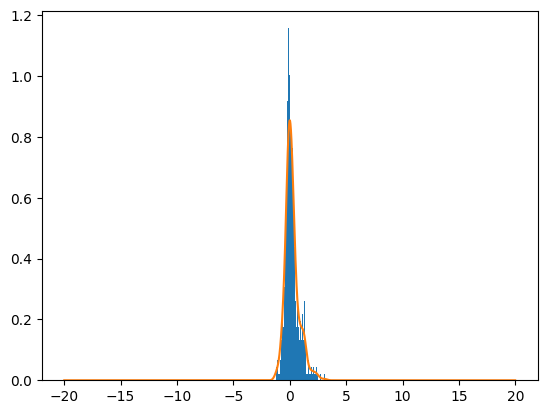

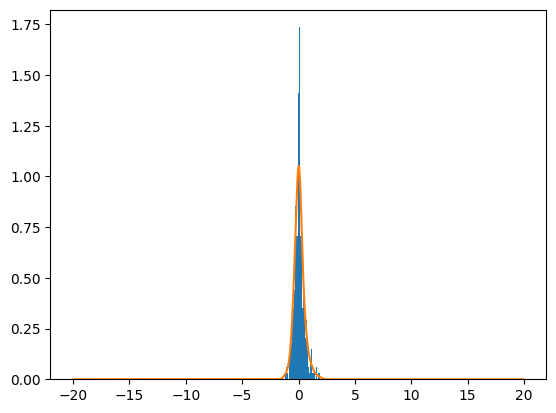

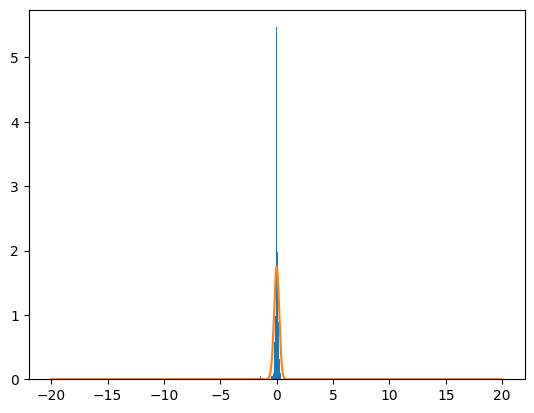

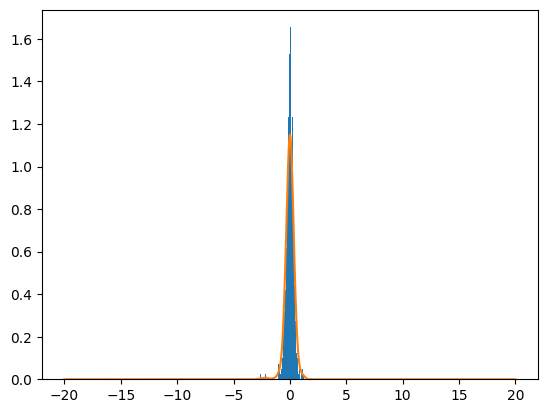

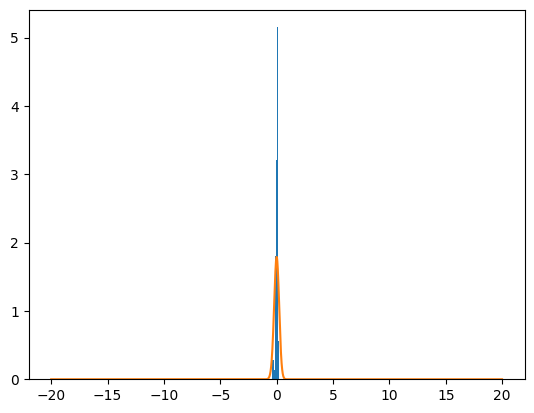

torch.Size([4000])
torch.Size([4000, 5])
700  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
701  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
702  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
703  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
704  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
705  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
706  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
707  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
708  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
709  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
710  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
711  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
712  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
713  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
714  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
715  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
716  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
717  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
718  loss=  tensor(0.66

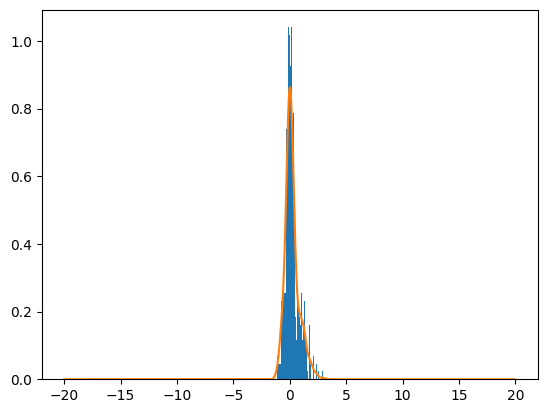

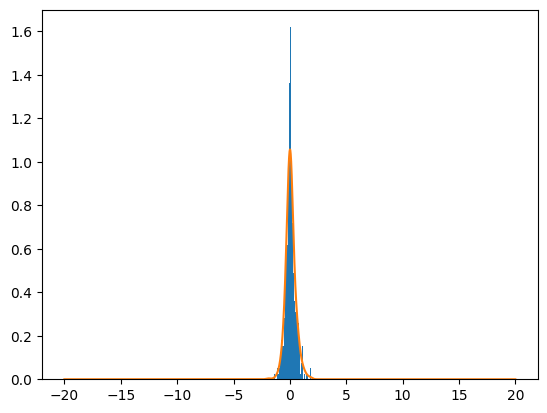

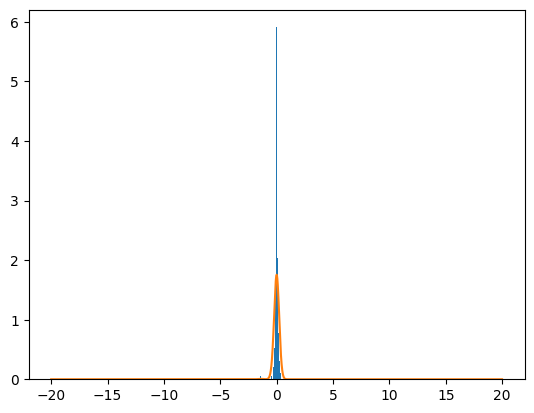

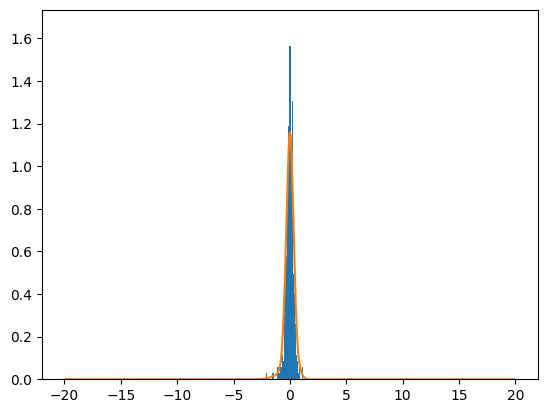

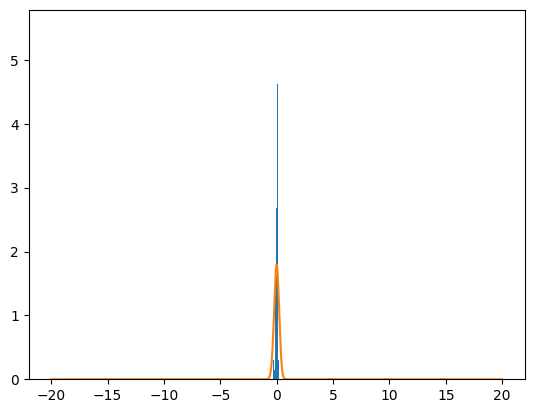

torch.Size([4000])
torch.Size([4000, 5])
750  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
751  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
752  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
753  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
754  loss=  tensor(0.6609, grad_fn=<MeanBackward0>)
755  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
756  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
757  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
758  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
759  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
760  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
761  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
762  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
763  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
764  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
765  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
766  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
767  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
768  loss=  tensor(0.66

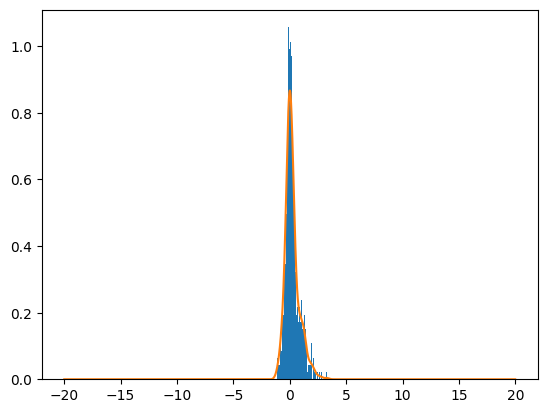

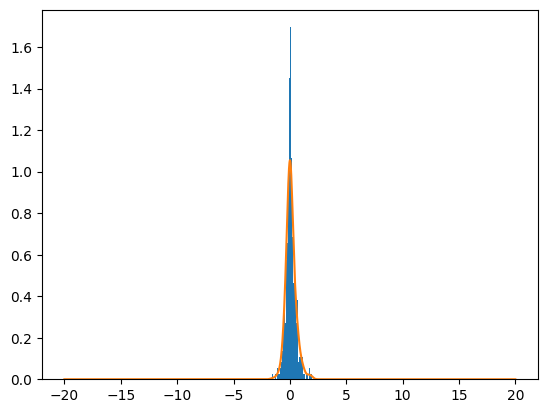

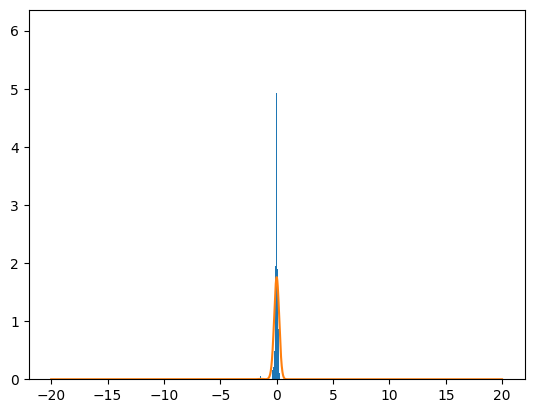

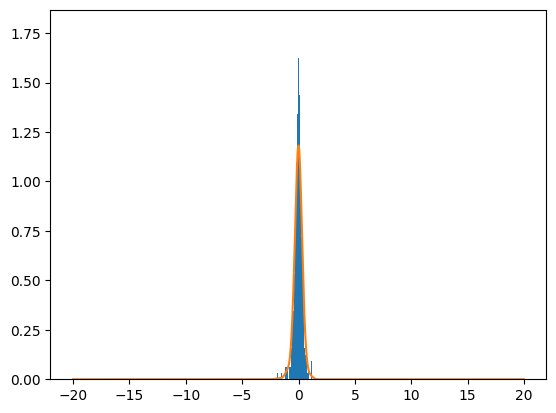

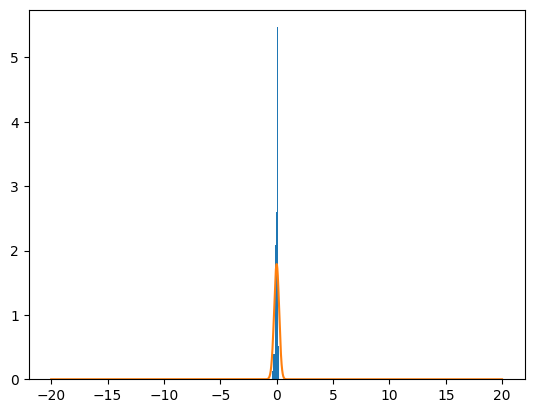

torch.Size([4000])
torch.Size([4000, 5])
800  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
801  loss=  tensor(0.6610, grad_fn=<MeanBackward0>)
802  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
803  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
804  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
805  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
806  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
807  loss=  tensor(0.6610, grad_fn=<MeanBackward0>)
808  loss=  tensor(0.6618, grad_fn=<MeanBackward0>)
809  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
810  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
811  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
812  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
813  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
814  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
815  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
816  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
817  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
818  loss=  tensor(0.66

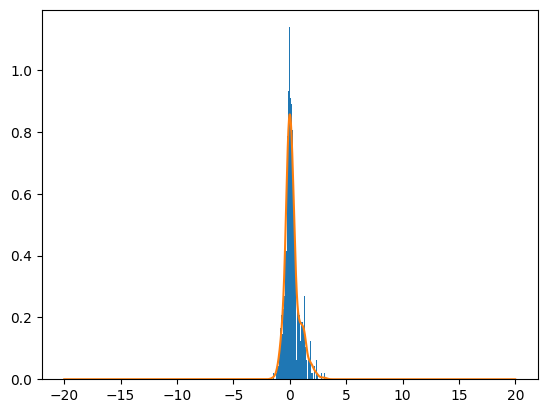

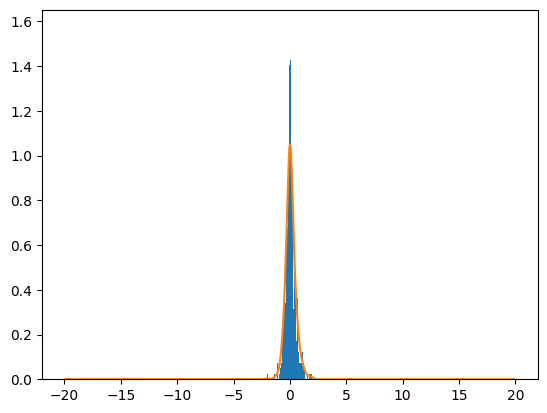

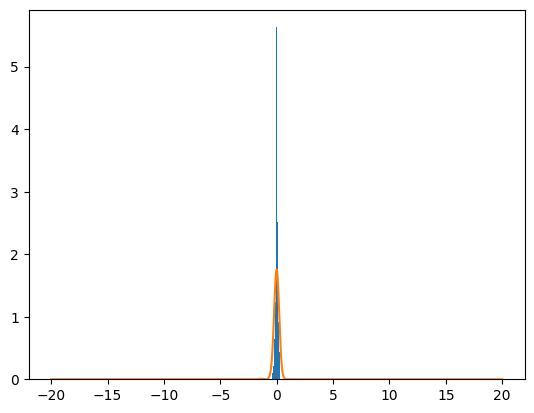

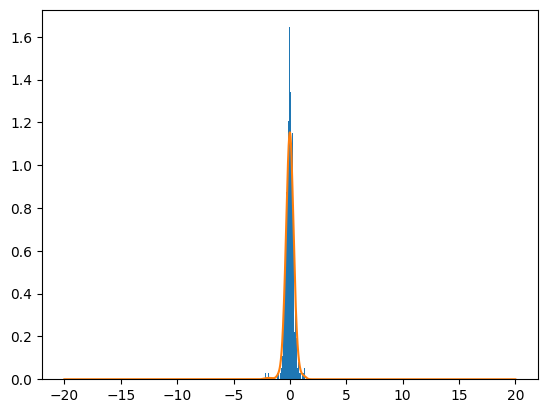

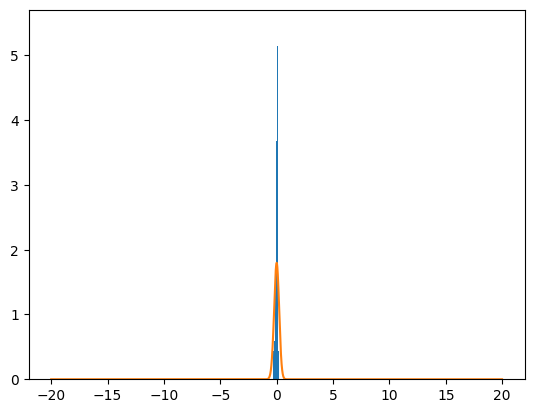

torch.Size([4000])
torch.Size([4000, 5])
850  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
851  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
852  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
853  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
854  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
855  loss=  tensor(0.6610, grad_fn=<MeanBackward0>)
856  loss=  tensor(0.6607, grad_fn=<MeanBackward0>)
857  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
858  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
859  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
860  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
861  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
862  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
863  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
864  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
865  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
866  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
867  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
868  loss=  tensor(0.66

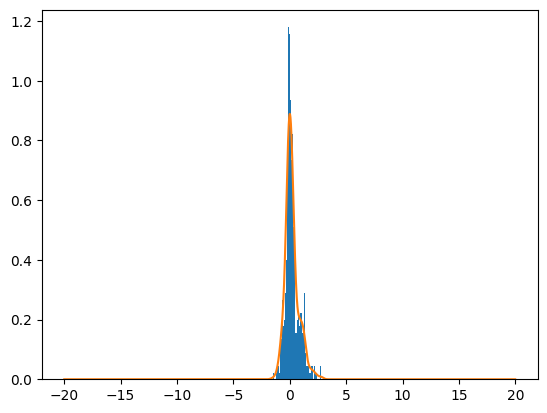

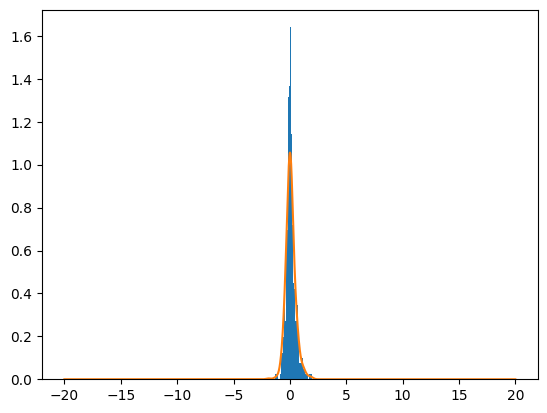

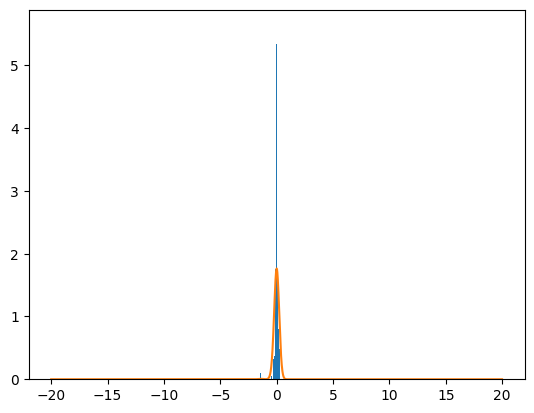

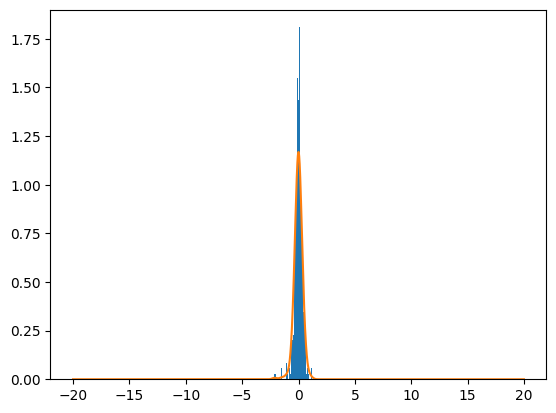

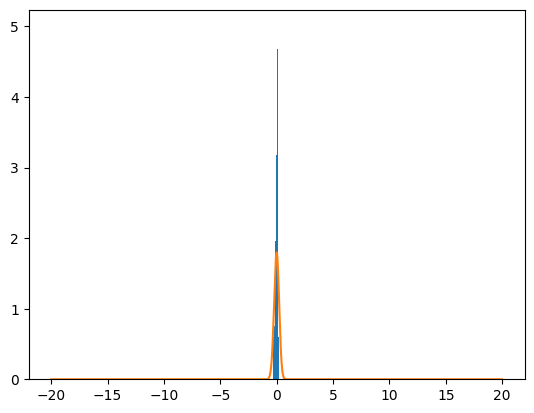

torch.Size([4000])
torch.Size([4000, 5])
900  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
901  loss=  tensor(0.6609, grad_fn=<MeanBackward0>)
902  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
903  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
904  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
905  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
906  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
907  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
908  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
909  loss=  tensor(0.6617, grad_fn=<MeanBackward0>)
910  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
911  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
912  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
913  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
914  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
915  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
916  loss=  tensor(0.6610, grad_fn=<MeanBackward0>)
917  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
918  loss=  tensor(0.66

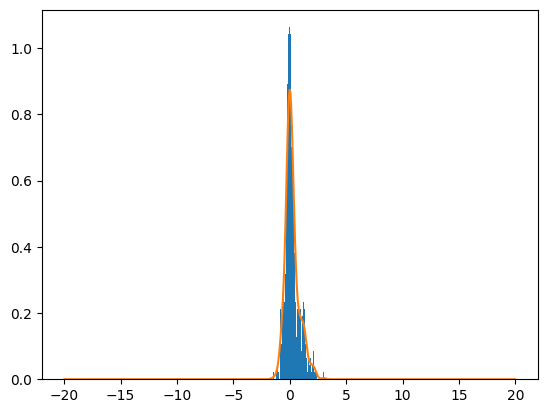

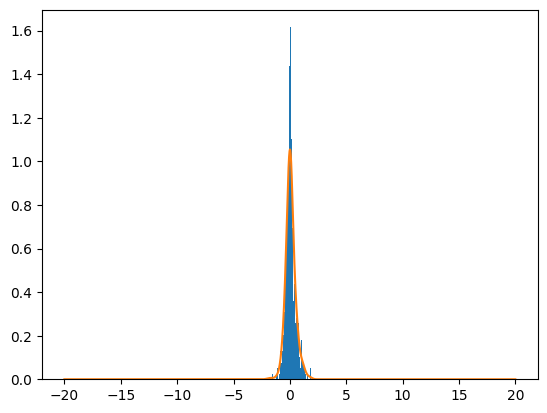

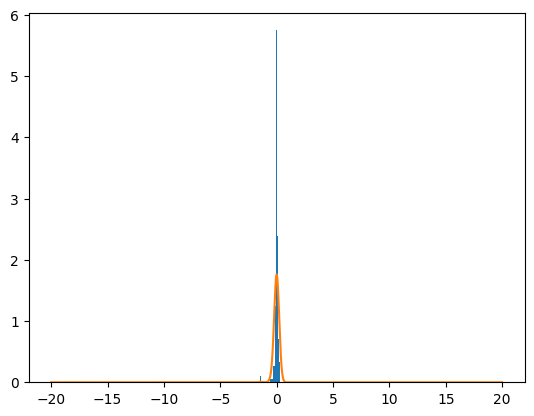

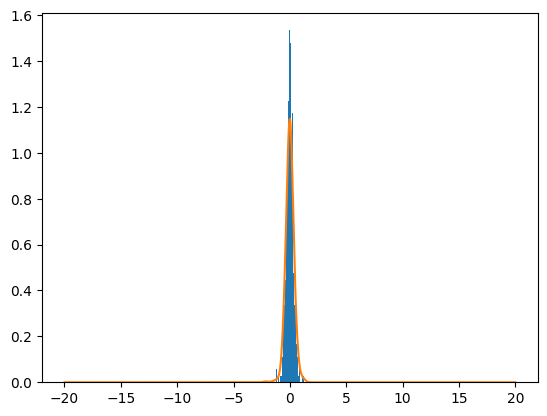

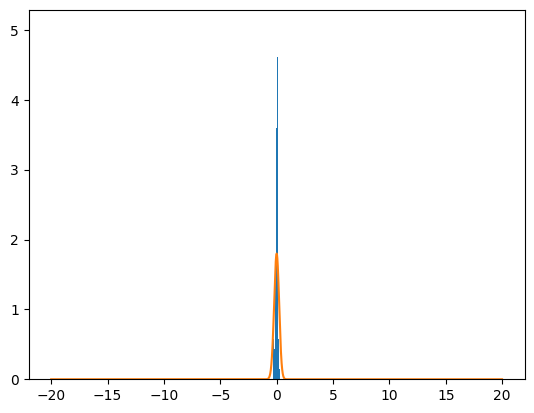

torch.Size([4000])
torch.Size([4000, 5])
950  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
951  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
952  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
953  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
954  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
955  loss=  tensor(0.6608, grad_fn=<MeanBackward0>)
956  loss=  tensor(0.6609, grad_fn=<MeanBackward0>)
957  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
958  loss=  tensor(0.6615, grad_fn=<MeanBackward0>)
959  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
960  loss=  tensor(0.6616, grad_fn=<MeanBackward0>)
961  loss=  tensor(0.6614, grad_fn=<MeanBackward0>)
962  loss=  tensor(0.6613, grad_fn=<MeanBackward0>)
963  loss=  tensor(0.6612, grad_fn=<MeanBackward0>)
964  loss=  tensor(0.6611, grad_fn=<MeanBackward0>)
965  loss=  tensor(0.6609, grad_fn=<MeanBackward0>)
966  loss=  tensor(0.6610, grad_fn=<MeanBackward0>)
967  loss=  tensor(0.6609, grad_fn=<MeanBackward0>)
968  loss=  tensor(0.66

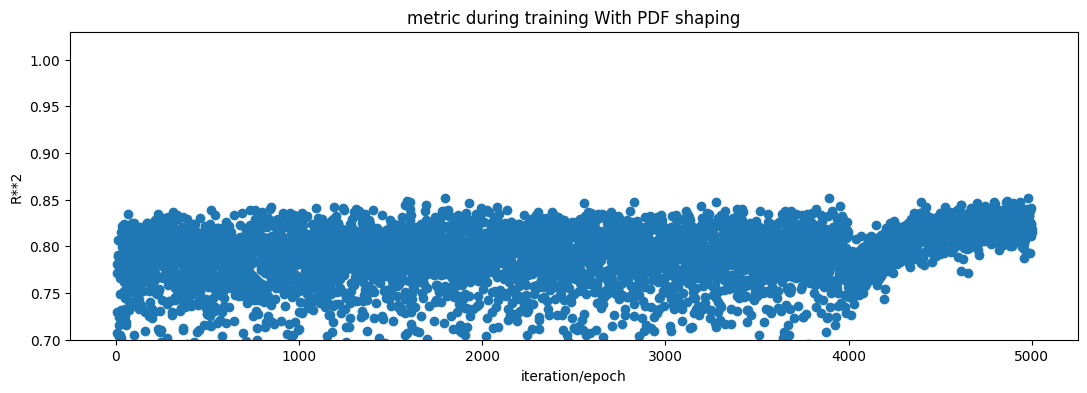

Training loss: tensor(0.1568, grad_fn=<MseLossBackward0>)
Training R**2: 0.824351640176034
Test loss - scaled: tensor(0.1551, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(10116357., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.8005515771882198
Testing R**2 - descaled: 0.8005515599995526
*****
*****
Testing R**2 - Output: 0 0.382840439529876
*****
*****
Testing R**2 - Output: 1 0.8181675579232994
*****
*****
Testing R**2 - Output: 2 0.9246523488372145
*****
*****
Testing R**2 - Output: 3 0.8875576527327287
*****
*****
Testing R**2 - Output: 4 0.9895397939133439


In [78]:

model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn     = F.mse_loss
loss_fn_PDF = my_loss_UNKNOWN_error_PDF

fit_y_scaled_PDF(N_EPOCHS, N_EPOCHS_PDF, model, loss_fn, loss_fn_PDF, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))


print_individual_Rsquare(pred_descaled, y_test_tr)
